In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import os
import pickle
import gc
import re

import matplotlib.pyplot as plt
import seaborn as sns
import numpy.random as random
from pandas import Series, DataFrame

import lightgbm as lgb
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.tree import  DecisionTreeRegressor

#分布確認
!pip install ydata_profiling
import ydata_profiling as pdp

#前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder,OneHotEncoder,OrdinalEncoder
#モデリング
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold,StratifiedGroupKFold
from sklearn.metrics import f1_score,recall_score, precision_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
dfff_train = pd.read_csv("/sumple/train.csv")
dfff_test = pd.read_csv("/sumple/test.csv")

dff_train = dfff_train.copy()
dff_test = dfff_test.copy()

In [ ]:
#学習データとテストデータを一旦結合しておく
df_all = pd.concat([dff_train, dff_test], keys=["train","test"]).reset_index(level =0)

In [ ]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f}MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
             pass

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
#メモリ削減の実行
df_all = reduce_mem_usage(df_all)
df_train = reduce_mem_usage(df_all)
df_test = reduce_mem_usage(df_all)

Memory usage of dataframe is 1.06MB
Memory usage after optimization is: 0.73 MB
Decreased by 31.9%
Memory usage of dataframe is 0.73MB
Memory usage after optimization is: 0.73 MB
Decreased by 0.0%
Memory usage of dataframe is 0.73MB
Memory usage after optimization is: 0.73 MB
Decreased by 0.0%


In [ ]:
#共通の前処理を行うため、確認
df_all.head()

,level_0,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken
0,train,0,50歳,Self Enquiry,2,900秒,Large Business,male,1.0,4.0,Basic,3.0,5,1,4,Executive,253905.0,未婚 車未所持 子供なし,1.0
1,train,1,56歳,Company Invited,1,14分,Salaried,Male,1.0,4.0,Standard,3.0,2,1,4,Senior Manager,404475.0,"離婚済み,車あり,子供無し",0.0
2,train,2,NaN,Self Enquiry,1,10分,Large Business,Female,1.0,3.0,Basic,3.0,4,0,4,Executive,278145.0,"結婚済み、自動車未所有,子供なし",1.0
3,train,3,三十七歳,Self Enquiry,2,1080秒,Small Business,female,1.0,3.0,Standard,4.0,1,0,5,Senior Manager,326805.0,離婚済み、車所持、子供無し,0.0
4,train,4,48歳,Company Invited,3,1020秒,Small Business,female,1.0,3.0,Basic,4.0,4,0,4,Executive,258435.0,独身／車所持／無子,1.0


In [ ]:
#目的変数確認
df_all["ProdTaken"].value_counts()

,count
ProdTaken,
0.0,2992
1.0,497


In [ ]:
#欠損値確認
df_all.isna().sum()

,0
level_0,0
id,0
Age,193
TypeofContact,18
CityTier,0
DurationOfPitch,252
Occupation,0
Gender,0
NumberOfPersonVisiting,0
NumberOfFollowups,57


In [ ]:
#前処理用に型変換
df_all["Age"] = df_all["Age"].astype(str)

In [ ]:
df_all["Age"].head()

,Age
0,50歳
1,56歳
2,nan
3,三十七歳
4,48歳


In [ ]:
# 全角数字を半角数字に変換するためのテーブルを作成
table = str.maketrans({chr(0xFF10 + i): chr(0x30 + i) for i in range(10)})

# NaN以外のデータを処理
for index, age in df_all["Age"].dropna().items():
    # age が数値型の場合は文字列に変換してから translate を適用
    if isinstance(age, (int, float)):
        normalized_age = str(age).translate(table)
    else:
        normalized_age = age.translate(table)
    df_all.loc[index, "Age"] = normalized_age
    df_all.loc[index, "Age_cleaned"] = normalized_age

In [ ]:
# 指定した文字を削除して表示
for index, age in df_all["Age_cleaned"].items():
    cleaned_age = age.replace('際', '').replace('歳', '').replace('才', '').replace('代', '')
    df_all.at[index, 'Age_cleaned'] = cleaned_age

df_all["Age_cleaned"].value_counts()

,count
Age_cleaned,
30,442
40,354
50,300
33,246
32,240
...,...
10,4
二十三,2
四十四,2


In [ ]:
#漢数字を変換
def convert_kanji_to_number(text):
    kanji_to_number = {
        "一": 1, "二": 2, "三": 3, "四": 4, "五": 5, "六": 6, "七": 7, "八": 8, "九": 9,
        "十": 10
    }
    result = 0
    temp_value = 0
    for char in text:
        if char in kanji_to_number:
            value = kanji_to_number[char]
            if value == 10:
                result += temp_value * 10
                temp_value = 0
            else:
                temp_value += value
    result += temp_value
    return result if result > 0 else text

# 適用前に "歳" を削除
df_all['Age_numeric'] = df_all['Age_cleaned'].str.replace("歳", "").apply(convert_kanji_to_number)

In [ ]:
df_all['Age_numeric'] = pd.to_numeric(df_all['Age_numeric'], errors='coerce')
df_all['Age_numeric'] = df_all['Age_numeric'].clip(lower=20, upper = 60)

In [ ]:
df_all["Age_numeric"].value_counts()

,count
Age_numeric,
30.0,454
40.0,360
50.0,306
33.0,272
32.0,252
36.0,246
34.0,244
37.0,240
35.0,234


In [ ]:
# 顧客への連絡方法:自分か企業からか
df_all["TypeofContact"].value_counts()

,count
TypeofContact,
Self Enquiry,4444
Company Invited,2516


In [ ]:
#都市層(1>2>3)
df_all["CityTier"].value_counts()

,count
CityTier,
2,3160
1,2991
3,827


In [ ]:
#営業担当者による顧客への売り込み時間
df_all["DurationOfPitch"].value_counts()

,count
DurationOfPitch,
8分,495
9分,488
15分,432
16分,408
14分,398
...,...
36分,10
1140秒,9
2160秒,5


In [ ]:
df_all["DurationOfPitch"] = df_all["DurationOfPitch"].astype(str)
# 新しい特徴量 "Pitch分" を作成
df_all["Pitch分"] = df_all["DurationOfPitch"].copy().values

In [ ]:
# 秒を削除
df_all['Pitch分'] = df_all['DurationOfPitch'].str.replace('秒', '')

# 数値に変換し、秒の場合は60で割る
df_all['Pitch_minutes'] = df_all['Pitch分'].apply(lambda x: int(x) / 60 if x.isdigit() else x)

In [ ]:
# 分を削除
df_all['Pitch_minutes'] = df_all['Pitch_minutes'].astype(str).str.replace('分', '')

df_all["Pitch_minutes"] = df_all["Pitch_minutes"].astype(float)
df_all['Pitch_minutes'] = df_all['Pitch_minutes'].astype('Int64')
df_all["Pitch_minutes"] = df_all["Pitch_minutes"].replace('nan', np.nan)

In [ ]:
#欠損値確認
df_all["Pitch_minutes"].isnull().sum()

252

In [ ]:
#顧客のご職業:中小、会社員、大企業
df_all["Occupation"].value_counts()

,count
Occupation,
Small Business,3456
Salaried,2801
Large Business,721


In [ ]:
df_all["Gender"].value_counts()

,count
Gender,
Male,2525
Female,1441
male,940
female,504
MALE,363
Ｍａｌｅ,260
Fe Male,213
FEMALE,197
Ｆｅｍａｌｅ,181


In [ ]:
df_all["Gender"] = df_all["Gender"].astype(str)
def convert_gender(gender):
  gender = gender.lower().replace(" ", "")  # 空白を削除して小文字に変換
  return gender  # 変換後の文字列を返す

df_all["Gender_enc"] = df_all["Gender"].apply(convert_gender)


In [ ]:
import unicodedata

df_all["Gender_enc"] = df_all["Gender_enc"].astype(str)

def convert_to_binary(gender):
    # 全角を半角に変換
    gender = unicodedata.normalize('NFKC', gender)
    # 全角英数字を半角英数字に変換
    gender = gender.translate(str.maketrans({chr(0xFF01 + i): chr(0x21 + i) for i in range(94)}))

    # 小文字に変換
    gender = gender.lower()

    # 修正箇所: "female" または "f" を含んでいるかを確認
    if "female" in gender or "f" in gender:
        return 0
    else:
        return 1

df_all["Gender_enc"] = df_all["Gender_enc"].apply(convert_to_binary)

In [ ]:
display(df_all[["Gender", "Gender_enc"]].sample(n=20))
# femaleが1

,Gender,Gender_enc
247,Male,1
877,Male,1
1237,Female,0
2568,Female,0
263,Fe Male,0
2075,male,1
1516,male,1
2179,Male,1
1203,Fe Male,0
2605,Fe Male,0


In [ ]:
#一緒に旅行を予定している人数の合計
df_all["NumberOfPersonVisiting"].value_counts()

,count
NumberOfPersonVisiting,
2.0,3163
3.0,2773
1.0,686
4.0,356


In [ ]:
df_all["NumberOfFollowups"].isnull().sum()

57

In [ ]:
#顧客によるホテル施設の優先評価
df_all["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
3.0,4328
4.0,2254
5.0,396


In [ ]:
#営業担当者による商品の売り込み
df_all["ProductPitched"].value_counts()

,count
ProductPitched,
Basic,1810
Deluxe,1660
Standard,1239
Super Deluxe,471
basic,218
...,...
Kıոg,1
Kiոg,1
Βasıc,1


In [ ]:
df_all["ProductPitched"] = df_all["ProductPitched"].astype(str)

def convert_gender_to_binary(product):
  # 全角を半角に変換し、空白を削除して小文字に変換
  product = unicodedata.normalize('NFKC', product).lower().replace(" ", "").replace("|", "l")

  return product

df_all["ProductPitched_low"] = df_all["ProductPitched"].apply(convert_gender_to_binary)

In [ ]:
def normalize_text(text):
  # 全角を半角に変換し、ギリシャ文字などを変換
  normalized_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8').lower()
  return normalized_text

df_all["ProductPitched_low"] = df_all["ProductPitched_low"].apply(normalize_text)

In [ ]:
def replace_multiple(text):
    # 正規表現によるbasic変換
    text = re.sub(r"^(ba?s?i?c?)+$", "basic", text)

    return text

df_all["ProductPitched_low"] = df_all["ProductPitched_low"].apply(replace_multiple)

In [ ]:
#basic残り
def replace_multiple(text):
    if text in ["asc", "asic", "asi"]:
        text = "basic"
    return text

df_all["ProductPitched_low"] = df_all["ProductPitched_low"].apply(replace_multiple)

In [ ]:
#king
def replace_multiple(text):
    if text in ["kig", "kng", "kg"]:
        text = "king"
    return text

df_all["ProductPitched_low"] = df_all["ProductPitched_low"].apply(replace_multiple)

In [ ]:
#deluxe
def replace_multiple(text):
    if text in ["eluxe","delue", "delux","dlux"]:
        text = "deluxe"
    return text

df_all["ProductPitched_low"] = df_all["ProductPitched_low"].apply(replace_multiple)

In [ ]:
#superdeluxe
def replace_multiple(text):
    if text in ["supereluxe","uperdeluxe", "superdluxe", "superdelue","supreluxe"]:
        text = "superdeluxe"
    return text

df_all["ProductPitched_low"] = df_all["ProductPitched_low"].apply(replace_multiple)

In [ ]:
#standard
def replace_multiple(text):
    if text in ["tandard","stadard","stndard","standar","stanard"]:
        text = "standard"
    return text

df_all["ProductPitched_low"] = df_all["ProductPitched_low"].apply(replace_multiple)

In [ ]:
df_all["ProductPitched_low"].value_counts()

,count
ProductPitched_low,
basic,2347
deluxe,2091
standard,1614
superdeluxe,640
king,286


In [ ]:
#顧客の年間旅行数
df_all["NumberOfTrips"].value_counts()

,count
NumberOfTrips,
2,1956
3,1461
5,836
1,669
7,445
年に2回,294
4,277
年に3回,245
6,234


In [ ]:
df_all["NumberOfTrips"] = df_all["NumberOfTrips"].astype(str)
def extract_trips(trips):
    if trips == "四半期に1回" or trips == "半年に1回":
        return trips  # "四半期に1回" と "半年に1回" はそのまま返す

    trips = trips.strip()  # trips の前後の空白や改行を削除

    original_trips = trips  # 元の値を保存

    # "年に" と "回" を削除
    trips = re.sub(r"年に?", "", trips)
    trips = re.sub(r"回?", "", trips)

    if trips.isdigit():  # trips が数字のみで構成されているか確認
        return int(trips)  # 数字のみであれば整数に変換して返す

    return original_trips  # それ以外の場合は元の値を返す

df_all["NumberOfTrips_year"] = df_all["NumberOfTrips"].apply(extract_trips)

In [ ]:
df_all["NumberOfTrips_year"].value_counts()

,count
NumberOfTrips_year,
2,2250
3,1706
5,977
1,801
7,513
4,327
6,281
nan,64
半年に1回,27


In [ ]:
#他のNumberを変換
df_all["NumberOfTrips_year"] = df_all["NumberOfTrips_year"].astype(str)
def replace_multiple(text):
    if text in ["半年に1回"]:
        text = 2
    elif text in ["四半期に1回"]:
        text = 4
    elif text == "nan":
        text = 0
    return text

df_all["NumberOfTrips_year"] = df_all["NumberOfTrips_year"].apply(replace_multiple)
df_all["NumberOfTrips_year"] = df_all["NumberOfTrips_year"].astype(int)
df_all["NumberOfTrips_year"].value_counts()

,count
NumberOfTrips_year,
2,2277
3,1706
5,977
1,801
7,513
4,333
6,281
0,64
8,26


In [ ]:
df_all["Passport"].value_counts()

,count
Passport,
0,6288
1,690


In [ ]:
#売り込みの満足度スコア
df_all["PitchSatisfactionScore"].value_counts()

,count
PitchSatisfactionScore,
2,2500
4,1452
1,1439
3,1344
5,243


In [ ]:
# 現在の組織における顧客の指定
df_all["Designation"].value_counts()

,count
Designation,
Executive,2219
Manager,2027
Senior Manager,1565
AVP,604
VP,259
...,...
Еxеcutivе,1
Еxecuｔive,1
E×ecｕtive,1


In [ ]:
df_all["Designation"] = df_all["Designation"].astype(str)

def convert_gender_to_binary(product):
  # 全角を半角に変換し、空白を削除して小文字に変換
  product = unicodedata.normalize('NFKC', product).lower().replace(" ", "").replace("|", "l")

  return product

df_all["Designation_low"] = df_all["Designation"].apply(convert_gender_to_binary)

In [ ]:
def normalize_text(text):
  # 全角を半角に変換し、ギリシャ文字などを変換
  normalized_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8').lower()
  return normalized_text

df_all["Designation_low"] = df_all["Designation_low"].apply(normalize_text)

In [ ]:
#executive
def replace_multiple(text):
    if text in ["excutive", "excutiv", "executiv","executie","xecutive",
                "eecutive", "excuti", "xecutiv", "executi", "cutive", "ecutive", "xcutiv","ecutie" ]:
        text = "executive"
    return text

df_all["Designation_low"] = df_all["Designation_low"].apply(replace_multiple)

In [ ]:
#manager
def replace_multiple(text):
    if text in ["anager", "managr", "manger", "mnager", "mnger", "nager",
                "mnagr", "mangr", "anagr", "nagr", "mngr" ]:
        text = "manager"
    return text

df_all["Designation_low"] = df_all["Designation_low"].apply(replace_multiple)

In [ ]:
#seniormanager
def replace_multiple(text):
    if text in ["seniormanagr", "sniormanager", "eniormanager", "seniormanger", "seniormnger", "enioranager",
                "sniormanagr", "seniormnager", "senioranager", "senioranger", "eniormanger" ]:
        text = "seniormanager"
    return text

df_all["Designation_low"] = df_all["Designation_low"].apply(replace_multiple)

In [ ]:
#vip
def replace_multiple(text):
    if text in ["avp", "vp" ]:
        text = "vip"
    return text

df_all["Designation_low"] = df_all["Designation_low"].apply(replace_multiple)

In [ ]:
df_all["Designation_low"].value_counts()

,count
Designation_low,
executive,2330
manager,2117
seniormanager,1632
vip,899


In [ ]:
#顧客の月収
df_all["MonthlyIncome"].head()

,MonthlyIncome
0,253905.0
1,404475.0
2,278145.0
3,326805.0
4,258435.0


In [ ]:
# df_all["MonthlyIncome"] をstr型に変換
df_all["MonthlyIncome"] = df_all["MonthlyIncome"].astype(str)

# 正規表現を使って数字を抽出
df_all["MonthlyIncome_ext"] = df_all["MonthlyIncome"].str.extract(r"月収(\d+\.?\d*)万円")

# 正規表現で抽出した値にのみ10000をかける
df_all["MonthlyIncome_ext"] = np.where(df_all["MonthlyIncome_ext"].notnull(), df_all["MonthlyIncome_ext"].astype(float) * 10000, df_all["MonthlyIncome"])

In [ ]:
df_all["MonthlyIncome"].head()

,MonthlyIncome
0,253905.0
1,404475.0
2,278145.0
3,326805.0
4,258435.0


In [ ]:
# 数値型に変換 ("nan" を NaN に変換)
df_all["MonthlyIncome_ext"] = pd.to_numeric(df_all["MonthlyIncome_ext"], errors='coerce')

In [ ]:
#顧客の情報のメモ(婚姻状況や車の有無、旅行の子どもの同伴の有無について記載されている)
df_all["customer_info"].value_counts()

,count
customer_info,
結婚済み、車未所持、子供1人,74
結婚済み、車所持、子供1人,57
未婚、車未所持、子供1人,41
結婚済み 車未所持 子供1人,41
結婚済み、車所持、子供2人,38
...,...
未婚/車なし/子供2人,1
未婚、車なし、2児,1
未婚/車所持／子供無し,1


In [ ]:
df_all["child_info"] = df_all["customer_info"].str.replace(r"[\s()]", "", regex=True)
child_info_temp1 = df_all["child_info"].str.extract(r"(子供.+|こども.+)")

child_info_temp3 = child_info_temp1.copy()
child_info_temp2 = df_all["customer_info"].str.extract(r"(1児|2児|3児|無子|不明|わからない|子育て状況不明|子の数不詳|非育児家庭)\s?")
df_all["child_info"] = child_info_temp3[0].fillna(child_info_temp2[0])

In [ ]:
# "customer_info" から  "customer_info_removed" を作成
df_all["customer_info_removed"] = df_all["customer_info"].str.replace(r"(子供|こども|1児|2児|3児|非育児家庭|無子|不明|わからない|子育て状況不明|子の数不詳).*\s?", "", regex=True)

In [ ]:
df_all["child_info"].value_counts()
df_all["child_info"].isna().sum()

0

In [ ]:
display(df_all[["customer_info", "customer_info_removed","child_info"]].sample(n=10))

,customer_info,customer_info_removed,child_info
1105,結婚済み\t車所持\tこども2人,結婚済み\t車所持\t,こども2人
3234,結婚済み、自動車所有、子供2人,結婚済み、自動車所有、,子供2人
3094,結婚済み/車未所持/子供1人,結婚済み/車未所持/,子供1人
3349,結婚済み\t自動車未所有\t子供1人,結婚済み\t自動車未所有\t,子供1人
1015,結婚済み\t車未所持\t子供1人,結婚済み\t車未所持\t,子供1人
3091,独身 車未所持 子供1人,独身 車未所持,子供1人
3203,結婚済み 車所持 子供有り 2人,結婚済み 車所持,子供有り2人
1637,"離婚済み,自動車未所有,こども1人","離婚済み,自動車未所有,",こども1人
2497,"結婚済み,車未所持,こども2人","結婚済み,車未所持,",こども2人
1391,"結婚済み、車所持,子供1人","結婚済み、車所持,",子供1人


In [ ]:
df_all["customer_info_removed"].value_counts()

,count
customer_info_removed,
結婚済み、車未所持、,248
結婚済み、車所持、,222
離婚済み、車所持、,160
結婚済み 車所持,159
結婚済み 車未所持,144
...,...
離婚済み／自家用車なし/,1
"未婚,自動車所有、",1
"独身、車なし,",1


In [ ]:
df_all["material_status"] = df_all["customer_info_removed"].str.extract(r"(結婚済み|未婚|離婚済み|独身|)")

In [ ]:
df_all["customer_info_rem2"] = df_all["customer_info_removed"].str.replace(r"(結婚済み|未婚|離婚済み|独身)", "", regex=True)

In [ ]:
df_all["material_status"].value_counts()

,count
material_status,
結婚済み,2846
離婚済み,1688
独身,1309
未婚,1135


In [ ]:
df_all["customer_info_rem2"].value_counts()

,count
customer_info_rem2,
、車未所持、,604
、車所持、,559
車未所持,387
車所持,362
、自動車未所有、,303
...,...
/車保有なし／,1
",車保有、",1
／車あり/,1


In [ ]:
df_all["car_status"] = df_all["customer_info_removed"].str.extract(r"(所持|未所持|未所有|所有|なし|あり|保有なし|保有)")

In [ ]:
df_all["car_status"].isna().sum()

0

In [ ]:
display(df_all[["customer_info", "child_info","material_status", "car_status"]].sample(n=10))

,customer_info,child_info,material_status,car_status
1205,離婚済み\t自家用車あり\t子供無し,子供無し,離婚済み,あり
1959,結婚済み、乗用車なし、子供1人,子供1人,結婚済み,なし
1397,結婚済み、自家用車あり、子供1人,子供1人,結婚済み,あり
2063,離婚済み／自動車所有／子供1人,子供1人,離婚済み,所有
3081,"結婚済み,自家用車あり,子供1人",子供1人,結婚済み,あり
15,独身 車所持 子供なし,子供なし,独身,所持
2637,未婚 自動車未所有 こども2人,こども2人,未婚,未所有
1706,結婚済み、車未所持、こども1人,こども1人,結婚済み,未所持
460,結婚済み/乗用車なし/子供有り 1人,子供有り1人,結婚済み,なし
871,独身、車未所持、こども1人,こども1人,独身,未所持


In [ ]:
df_all["child_info"].value_counts()

,count
child_info,
子供1人,1699
子供なし,1038
子供2人,921
こども1人,832
子供無し,507
こども2人,456
子供有り1人,383
子供有り2人,236
1児,220


In [ ]:
# child_info_int 列をコピー
df_all['child_info_int'] = df_all['child_info'].copy()

# 数値に変換できる値を整数に変換
df_all['child_info_int'] = pd.to_numeric(df_all['child_info_int'].str.extract(r'(\d+)')[0], errors='coerce')

# 整数に変換できなかった場合は元の値を保持
df_all['child_info_int'] = df_all['child_info_int'].fillna(df_all['child_info'])

In [ ]:
df_all["child_info_cat"] =df_all["child_info_int"].copy()

In [ ]:
df_all["child_info_int"].value_counts()

,count
child_info_int,
1.0,3134
2.0,1721
子供なし,1038
子供無し,507
3.0,140
子供ゼロ,125
無子,121
非育児家庭,118
子供の数不明,39


In [ ]:
def convert_child_info(value):
  if value in ["子供なし", "子供無し","子供ゼロ", "無子", "非育児家庭","子供の数不明", "不明","子育て状況不明", "子の数不詳", "わからない"]:
    return 0
  else:
    return value

df_all["child_info_int"] = df_all["child_info_int"].apply(convert_child_info)

In [ ]:
df_all["child_info_int"].value_counts()

,count
child_info_int,
1.0,3134
0.0,1983
2.0,1721
3.0,140


In [ ]:
def convert_child_info1(value):
  if value in ["子供なし", "子供無し","子供ゼロ", "無子", "非育児家庭"]:
    return 0
  elif value in ["子供の数不明", "不明","子育て状況不明", "子の数不詳", "わからない"]:
    return -1
  else:
    return value

df_all["child_info_cat"] = df_all["child_info_cat"].apply(convert_child_info1)

In [ ]:
df_all["child_info_cat"].value_counts()

,count
child_info_cat,
1.0,3134
0.0,1909
2.0,1721
3.0,140
-1.0,74


In [ ]:
# #離婚済は経済環境に直結していると考えて残しておく
df_all['material_count'] = df_all['material_status'].copy()

def convert_material_info(value):
  if value in ["結婚済み"]:
    return 2
  elif value in ["離婚済み"]:
    return 1
  elif value in ["独身", "未婚"]:
    return 0
  else:
    return value

df_all["material_count"] = df_all["material_count"].apply(convert_material_info)

In [ ]:
df_all["material_status"].value_counts()

,count
material_status,
結婚済み,2846
離婚済み,1688
独身,1309
未婚,1135


In [ ]:
df_all["material_count"].value_counts()

,count
material_count,
2,2846
0,2444
1,1688


In [ ]:
df_all["car_status"].value_counts()

,count
car_status,
所持,1787
未所持,1674
未所有,887
なし,856
所有,789
あり,583
保有なし,202
保有,200


In [ ]:
# 元の特徴量も残しておく
df_all['car_status_count'] = df_all['car_status'].copy()

def convert_car_info(value):
  if value in ["所持","所有", "あり", "保有"]:
    return 1
  elif value in ["未所持", "未所有", "なし","保有なし", ""]:
    return 0
  else:
    return value

df_all["car_status_count"] = df_all["car_status_count"].apply(convert_car_info)

In [ ]:
df_all["car_status_count"].value_counts()

,count
car_status_count,
0,3619
1,3359


In [ ]:
df_all.isnull().sum()

,0
level_0,0
id,0
Age,0
TypeofContact,18
CityTier,0
DurationOfPitch,0
Occupation,0
Gender,0
NumberOfPersonVisiting,0
NumberOfFollowups,57


In [ ]:
#型の確認
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6978 entries, 0 to 3488
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   level_0                 6978 non-null   object 
 1   id                      6978 non-null   int16  
 2   Age                     6978 non-null   object 
 3   TypeofContact           6960 non-null   object 
 4   CityTier                6978 non-null   int8   
 5   DurationOfPitch         6978 non-null   object 
 6   Occupation              6978 non-null   object 
 7   Gender                  6978 non-null   object 
 8   NumberOfPersonVisiting  6978 non-null   float16
 9   NumberOfFollowups       6921 non-null   float16
 10  ProductPitched          6978 non-null   object 
 11  PreferredPropertyStar   6978 non-null   float16
 12  NumberOfTrips           6978 non-null   object 
 13  Passport                6978 non-null   int8   
 14  PitchSatisfactionScore  6978 non-null   int8 

In [ ]:
#型変換の微調整
df_all["Passport"] = df_all["Passport"].astype(int)
df_all["PitchSatisfactionScore"] = df_all["PitchSatisfactionScore"].astype(int)

In [ ]:
for col in df_all.columns:
  if df_all[col].dtype == 'float16':
    df_all[col] = df_all[col].astype('float64')

In [ ]:
for col in df_all.columns:
  if df_all[col].dtype == "int8":
    df_all[col] = df_all[col].astype("int64")

In [ ]:
for col in df_all.columns:
  if df_all[col].dtype == "object":
    df_all[col] = df_all[col].astype("category")

In [ ]:
for col in df_all.columns:
  if df_all[col].dtype == "int16":
    df_all[col] = df_all[col].astype("int64")

In [ ]:
#ここまで共通の前処理
df_all0 = df_all.copy()

In [ ]:
#ここからtrainとtestへ戻してそれぞれ特徴量生成を行う
df_train = df_all0[df_all0["level_0"] == "train"].drop(columns = ["level_0"])
df_test = df_all0[df_all0["level_0"] == "test"].drop(columns = ["level_0"])

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3489 entries, 0 to 3488
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   id                      3489 non-null   int64   
 1   Age                     3489 non-null   category
 2   TypeofContact           3483 non-null   category
 3   CityTier                3489 non-null   int64   
 4   DurationOfPitch         3489 non-null   category
 5   Occupation              3489 non-null   category
 6   Gender                  3489 non-null   category
 7   NumberOfPersonVisiting  3489 non-null   float64 
 8   NumberOfFollowups       3456 non-null   float64 
 9   ProductPitched          3489 non-null   category
 10  PreferredPropertyStar   3489 non-null   float64 
 11  NumberOfTrips           3489 non-null   category
 12  Passport                3489 non-null   int64   
 13  PitchSatisfactionScore  3489 non-null   int64   
 14  Designation             3489 

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3489 entries, 0 to 3488
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   id                      3489 non-null   int64   
 1   Age                     3489 non-null   category
 2   TypeofContact           3477 non-null   category
 3   CityTier                3489 non-null   int64   
 4   DurationOfPitch         3489 non-null   category
 5   Occupation              3489 non-null   category
 6   Gender                  3489 non-null   category
 7   NumberOfPersonVisiting  3489 non-null   float64 
 8   NumberOfFollowups       3465 non-null   float64 
 9   ProductPitched          3489 non-null   category
 10  PreferredPropertyStar   3489 non-null   float64 
 11  NumberOfTrips           3489 non-null   category
 12  Passport                3489 non-null   int64   
 13  PitchSatisfactionScore  3489 non-null   int64   
 14  Designation             3489 

In [ ]:
# 頻度を計算
type_counts = df_train["TypeofContact"].value_counts()

# 頻度に基づいて値をソート (降順)
sorted_types = type_counts.sort_values(ascending=False).index.tolist()

# sorted_types に nan を追加
sorted_types.append(np.nan)

# OrdinalEncoderを作成 (NaN に -1 を割り当てる)
oe = OrdinalEncoder(categories=[sorted_types], encoded_missing_value=-1, handle_unknown="use_encoded_value", unknown_value=-1)  # handle_unknownとunknown_valueを追加

# df_train に対してエンコード
df_train["TypeofContact_oe"] = oe.fit_transform(df_train[["TypeofContact"]])

# df_test に対してエンコード (fit_transformではなくtransformを使用)
df_test["TypeofContact_oe"] = oe.transform(df_test[["TypeofContact"]])  # transformに変更

In [ ]:
df_train["TypeofContact_oe"].value_counts()

,count
TypeofContact_oe,
0.0,2194
1.0,1289
-1.0,6


In [ ]:
df_test["TypeofContact_oe"].value_counts()

,count
TypeofContact_oe,
0.0,2250
1.0,1227
-1.0,12


In [ ]:
#version２
# df_train に TypeofContact_binary カラムを追加
df_train['TypeofContact_binary'] = df_train['TypeofContact'].map({'Self Enquiry': 0, 'Company Invited': 1}).fillna(0).astype("category")

# df_test に TypeofContact_binary カラムを追加
df_test['TypeofContact_binary'] = df_test['TypeofContact'].map({'Self Enquiry': 0, 'Company Invited': 1}).fillna(0).astype("category")

In [ ]:
df_train['TypeofContact_binary'].value_counts()

,count
TypeofContact_binary,
0,2200
1,1289


In [ ]:
df_test['TypeofContact_binary'].value_counts()

,count
TypeofContact_binary,
0,2262
1,1227


In [ ]:
#頻度を計算
occupation_counts = df_train["Occupation"].value_counts()

# 頻度に基づいて値をソート (降順)
sorted_occupations = occupation_counts.sort_values(ascending=False).index.tolist()

# OrdinalEncoderを作成
# handle_unknownとunknown_valueを追加
oe = OrdinalEncoder(categories=[sorted_occupations], handle_unknown="use_encoded_value", unknown_value=-1)

# df_train に対してエンコード
df_train["Occupation_oe"] = oe.fit_transform(df_train[["Occupation"]])

# df_test に対してエンコード
df_test["Occupation_oe"] = oe.transform(df_test[["Occupation"]])

In [ ]:
df_train["Occupation_oe"].value_counts()

,count
Occupation_oe,
0.0,1727
1.0,1401
2.0,361


In [ ]:
df_test["Occupation_oe"].value_counts()

,count
Occupation_oe,
0.0,1729
1.0,1400
2.0,360


In [ ]:
# df_train に対してワンホットエンコーディング
gender_encoded_train = pd.get_dummies(df_train["Gender_enc"], prefix="Gender", dtype=int)
df_train = pd.concat([df_train, gender_encoded_train], axis=1)

# df_test に対してワンホットエンコーディング
gender_encoded_test = pd.get_dummies(df_test["Gender_enc"], prefix="Gender", dtype=int)
df_test = pd.concat([df_test, gender_encoded_test], axis=1)

In [ ]:
#100以上の外れ値を最大値補完
df_train['NumberOfFollowups_max'] = df_train['NumberOfFollowups'].apply(lambda x: x / 100 if x >= 100 else x)

# df_test に NumberOfFollowups_max カラムを追加
df_test['NumberOfFollowups_max'] = df_test['NumberOfFollowups'].apply(lambda x: x / 100 if x >= 100 else x)

In [ ]:
df_train['NumberOfFollowups_max'].value_counts()

,count
NumberOfFollowups_max,
4.0,1411
3.0,1296
5.0,524
2.0,108
1.0,78
6.0,39


In [ ]:
df_test['NumberOfFollowups_max'].isnull().sum()

24

In [ ]:
#nanを活かす方向でも残しておく
# df_train に NumberOfFollowups_nan-1 カラムを追加
df_train['NumberOfFollowups_nan-1'] = pd.to_numeric(df_train['NumberOfFollowups_max'], errors='coerce').fillna(-1).astype(int)
df_train.loc[df_train['NumberOfFollowups'].isin(['0', 0]), 'NumberOfFollowups_nan-1'] = -1

# df_test に NumberOfFollowups_nan-1 カラムを追加
df_test['NumberOfFollowups_nan-1'] = pd.to_numeric(df_test['NumberOfFollowups_max'], errors='coerce').fillna(-1).astype(int)
df_test.loc[df_test['NumberOfFollowups'].isin(['0', 0]), 'NumberOfFollowups_nan-1'] = -1

In [ ]:
df_train["NumberOfFollowups_nan-1"].value_counts()

,count
NumberOfFollowups_nan-1,
4,1411
3,1296
5,524
2,108
1,78
6,39
-1,33


(array([   0.,   78., 1404., 1974.]),
 array([0., 1., 2., 4., 6.]),
 <BarContainer object of 4 artists>)

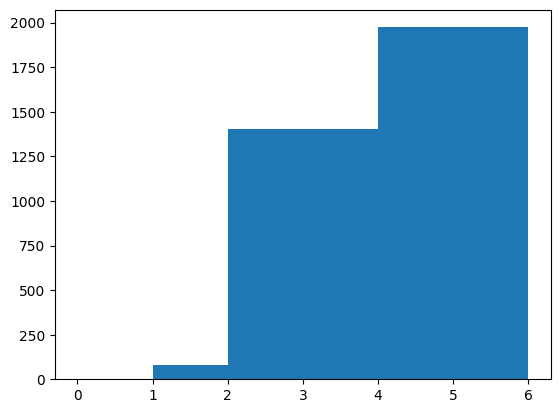

In [ ]:
plt.hist(df_train["NumberOfFollowups_nan-1"], bins=[0, 1, 2,4,6])

In [ ]:
#最頻値を取得
most_frequent_value = df_train['NumberOfFollowups_max'].mode()[0]

# df_train に適用 (NaN 値と 0 を同時に置換)
df_train['NumberOfFollowups_max'] = df_train['NumberOfFollowups_max'].replace({0: most_frequent_value, np.nan: most_frequent_value})

# df_test にも同様の処理を適用
df_test['NumberOfFollowups_max'] = df_test['NumberOfFollowups_max'].replace({0: most_frequent_value, np.nan: most_frequent_value})

In [ ]:
print(df_train['NumberOfFollowups_max'].isnull().sum())  # NaN 値の数を表示
print(df_train['NumberOfFollowups_max'].value_counts())  # 各値の出現回数を表示


0
NumberOfFollowups_max
4.0    1444
3.0    1296
5.0     524
2.0     108
1.0      78
6.0      39
Name: count, dtype: int64


In [ ]:
#各意味合いに沿ってrank化
rank_dict = {
    'king': 5,
    'superdeluxe': 4,
    'deluxe': 3,
    'standard': 2,
    'basic': 1
}


df_train['ProductPitched_Score'] = df_train['ProductPitched_low'].map(rank_dict)

# df_test にも ProductPitched_Score カラムを追加
df_test['ProductPitched_Score'] = df_test['ProductPitched_low'].map(rank_dict)

In [ ]:
df_train["ProductPitched_Score"] = df_train["ProductPitched_Score"].astype(int)
df_test["ProductPitched_Score"] = df_test["ProductPitched_Score"].astype(int)

In [ ]:
#欠損値として扱う特徴量としておく
df_train["NumberOfTrips_year-1"] = df_train["NumberOfTrips_year"].replace(0, -1)

df_test["NumberOfTrips_year-1"] = df_test["NumberOfTrips_year"].replace(0, -1)

df_train["NumberOfTrips_year-1"].value_counts()

,count
NumberOfTrips_year-1,
2,1164
3,820
5,515
1,409
7,256
4,163
6,130
-1,22
8,10


In [ ]:
#スコア化した良い商品*満足度のスコア
#→売り込み商品が良くて満足度が高ければ成約率も高いはず
df_train["Product_Score"] = df_train["ProductPitched_Score"]*df_train["PitchSatisfactionScore"]

df_test["Product_Score"] = df_test["ProductPitched_Score"]*df_test["PitchSatisfactionScore"]

df_train["Product_Score"].value_counts()

,count
Product_Score,
4,684
2,652
6,559
3,449
12,311
8,241
9,185
1,157
10,52


In [ ]:
df_test["Product_Score"].value_counts()

,count
Product_Score,
2,653
4,623
6,547
3,446
12,309
8,219
1,204
9,174
10,79


In [ ]:
#スコア化した良い商品*顧客によるホテル施設の優先評価
#→良い商品であり、施設の評価も高ければ成約率が高くなりそう
df_train["Product_Property_Score"] = df_train["ProductPitched_Score"] * df_train["PreferredPropertyStar"]

# df_test に Product_Property_Score カラムを追加
df_test["Product_Property_Score"] = df_test["ProductPitched_Score"] * df_test["PreferredPropertyStar"]

In [ ]:
# 頻度を計算
product_counts = df_train["Designation_low"].value_counts()  # df_train に変更

# 頻度に基づいて値をソート
sorted_products = product_counts.index.tolist()

# ラベルエンコーダーを作成
le = LabelEncoder()

# 頻度に基づいてラベルをエンコード (df_train で fit)
le.fit(df_train["Designation_low"])  # df_train["Designation_low"] で fit

# df_train に Designation_le カラムを追加
df_train["Designation_le"] = le.transform(df_train["Designation_low"])

# df_test に Designation_le カラムを追加 (df_train で fit した le を使用)
df_test["Designation_le"] = le.transform(df_test["Designation_low"])

In [ ]:
df_train["Designation_le"].value_counts()

,count
Designation_le,
0,1150
1,1055
2,854
3,430


In [ ]:
#rank化して使用する特徴量として作成
rank_dict = {
    'vip': 4,
    'executive': 3,
    'seniormanager': 2,
    'manager': 1
}

# df_train に Designation_rank カラムを追加
df_train["Designation_rank"] = df_train["Designation_low"].map(rank_dict)

# df_test に Designation_rank カラムを追加
df_test["Designation_rank"] = df_test["Designation_low"].map(rank_dict)

In [ ]:
df_train["Designation_rank"].value_counts()

,count
Designation_rank,
3,1150
1,1055
2,854
4,430


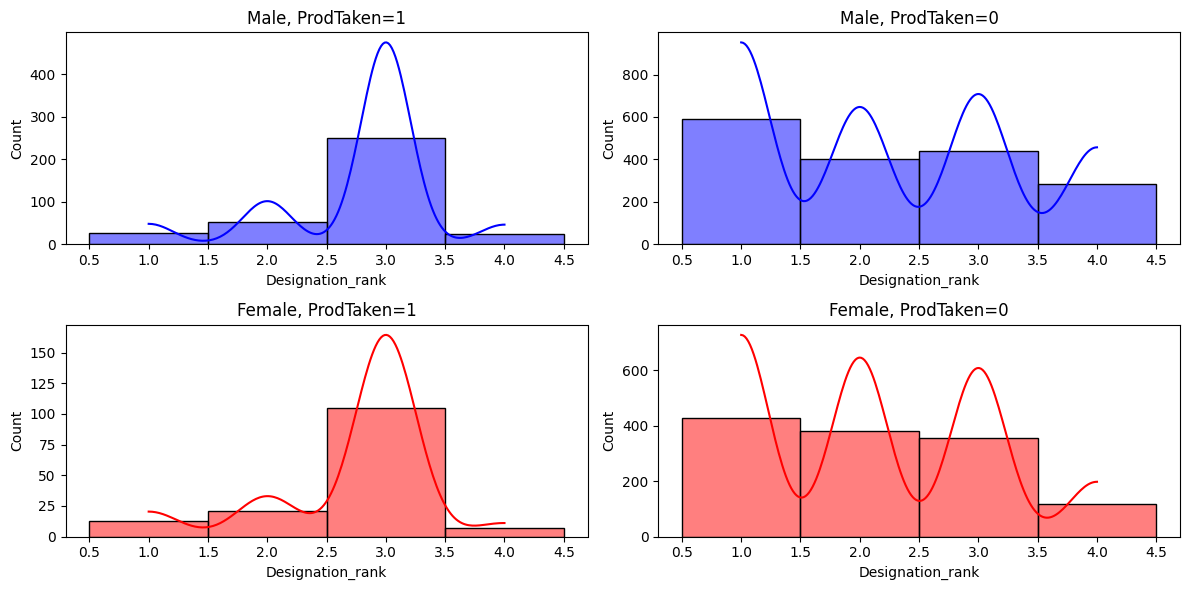

In [ ]:
# Gender_encとProdTakenでデータを分割
#特徴量を変えて視覚化
male_prodtaken_data = df_train[(df_train['Gender_enc'] == 1) & (df_train['ProdTaken'] == 1)]['Designation_rank']
male_notprodtaken_data = df_train[(df_train['Gender_enc'] == 1) & (df_train['ProdTaken'] == 0)]['Designation_rank']
female_prodtaken_data = df_train[(df_train['Gender_enc'] == 0) & (df_train['ProdTaken'] == 1)]['Designation_rank']
female_notprodtaken_data = df_train[(df_train['Gender_enc'] == 0) & (df_train['ProdTaken'] == 0)]['Designation_rank']

# 全データのDesignation_rankの最小値と最大値を取得
min_rank = df_train['Designation_rank'].astype(int).min()
max_rank = df_train['Designation_rank'].astype(int).max()

# binのエッジを指定 (例: 最小値から最大値までを1刻み)
bins = np.arange(min_rank, max_rank + 2, 1)  # +2は最大値を含めるため

# ヒストグラムを作成
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(male_prodtaken_data, color='blue', kde=True, bins=bins)  # bins引数を指定
plt.title('Male, ProdTaken=1')

plt.subplot(2, 2, 2)
sns.histplot(male_notprodtaken_data, color='blue', kde=True, bins=bins)  # bins引数を指定
plt.title('Male, ProdTaken=0')

plt.subplot(2, 2, 3)
sns.histplot(female_prodtaken_data, color='red', kde=True, bins=bins)  # bins引数を指定
plt.title('Female, ProdTaken=1')

plt.subplot(2, 2, 4)
sns.histplot(female_notprodtaken_data, color='red', kde=True, bins=bins)  # bins引数を指定
plt.title('Female, ProdTaken=0')
plt.tight_layout()
plt.show()

In [ ]:
# 欠損値として扱う
df_train["MonthlyIncome_ext-1"] = pd.to_numeric(df_train["MonthlyIncome_ext"], errors='coerce').fillna(-1).astype(int)

# df_test に MonthlyIncome_ext-1 カラムを追加
df_test["MonthlyIncome_ext-1"] = pd.to_numeric(df_test["MonthlyIncome_ext"], errors='coerce').fillna(-1).astype(int)

In [ ]:
#0 を含む欠損値を中央値で補完した特徴量も作成
median_income_train = df_train["MonthlyIncome_ext"].median()


df_train["MonthlyIncome_0_med"] = df_train["MonthlyIncome_ext"].copy()
df_train.loc[df_train["MonthlyIncome_0_med"] == 0, "MonthlyIncome_0_med"] = np.nan
df_train["MonthlyIncome_0_med"] = df_train["MonthlyIncome_0_med"].fillna(median_income_train)

# df_test にも同様の処理を適用
df_test["MonthlyIncome_0_med"] = df_test["MonthlyIncome_ext"].copy()
df_test.loc[df_test["MonthlyIncome_0_med"] == 0, "MonthlyIncome_0_med"] = np.nan
df_test["MonthlyIncome_0_med"] = df_test["MonthlyIncome_0_med"].fillna(median_income_train)

# 確認
print(df_train["MonthlyIncome_0_med"].isnull().sum())

0


In [ ]:
# MonthlyIncome_0_med を更新 (百の位を四捨五入)
df_train["MonthlyIncome_0_med"] = (df_train["MonthlyIncome_0_med"] / 1000).round() * 1000

df_test["MonthlyIncome_0_med"] = (df_test["MonthlyIncome_0_med"] / 1000).round() * 1000

In [ ]:
df_train["MonthlyIncome_0_med"].isnull().sum()

0

In [ ]:
# 離婚はしているが一人暮らしでない可能性もあるため、数値割り振りを変えたもの
def convert_material_info2(value):
  if value in ["結婚済み"]:
    return 3
  elif value in ["離婚済み"]:
    return 2
  elif value in ["独身", "未婚"]:
    return 1
  else:
    return value

# df_trainに適用
df_train['material_count2'] = df_train['material_status'].copy()
df_train["material_score"] = df_train["material_count2"].apply(convert_material_info2)

# df_testに適用
df_test['material_count2'] = df_test['material_status'].copy()
df_test["material_score"] = df_test["material_count2"].apply(convert_material_info2)

In [ ]:
#後々カテゴリ扱いとする
df_train["material_score"].value_counts()

,count
material_score,
3,1384
1,1227
2,878


In [ ]:
#df_all["material_count"]の結婚済みは２、それ以外は１とする。コピーなり一時的に違う変数に代入するなり。
#足算してdf_all["family"] へ代入し家族構成を表す特徴量とする。

# df_trainへの適用
df_train["material_temp"] =  np.where(df_train["material_count"] == 0, 1, df_train["material_count"])
df_train["child_temp"] = df_train["child_info_int"]
df_train["family"] = df_train["material_temp"] + df_train["child_temp"]
df_train["family"] = df_train["family"].astype(int)
df_train = df_train.drop(["material_temp", "child_temp"], axis=1)

# df_testへの適用
df_test["material_temp"] = np.where(df_test["material_count"] == 0, 1, df_test["material_count"])
df_test["child_temp"] = df_test["child_info_int"]
df_test["family"] = df_test["material_temp"] + df_test["child_temp"]
df_test["family"] = df_test["family"].astype(int)
df_test = df_test.drop(["material_temp", "child_temp"], axis=1)

# 既婚 + 子供有無
# 未婚・離婚 + 子供有無

In [ ]:
df_train["family"].value_counts()

,count
family,
2,1235
3,1139
1,690
4,392
5,33


In [ ]:
# NumberOfPersonVisiting と family の組み合わせごとの人数をカウント
#旅行同行者と家族構成の割合

# 集約テーブルの作成 (df_trainまたはdf_testを使用)
df_fam = pd.crosstab(df_train["NumberOfPersonVisiting"], df_train["family"], normalize="index")  # df_trainを使用
df_fam = df_fam.reset_index()
df_fam = pd.melt(df_fam, id_vars="NumberOfPersonVisiting", value_name="family_travel_share")

# df_trainへの適用
df_train = pd.merge(df_train, df_fam, on=["NumberOfPersonVisiting", "family"], how="left")

# df_testへの適用
df_test = pd.merge(df_test, df_fam, on=["NumberOfPersonVisiting", "family"], how="left")

# 全体の要素数で割って比率を計算.%が多いほど子供を連れていく可能性が高い
#意外と一人旅の割合高い可能性

In [ ]:
df_test["family_travel_share"].value_counts()

,count
family_travel_share,
0.501866,780
0.481481,660
0.268035,466
0.246187,380
0.230100,309
0.209877,279
0.693452,231
0.306548,119
0.062455,77


In [ ]:
df_train["family"].value_counts()

,count
family,
2,1235
3,1139
1,690
4,392
5,33


In [ ]:
df_train["NumberOfPersonVisiting"].value_counts()

,count
NumberOfPersonVisiting,
2.0,1608
3.0,1377
1.0,336
4.0,168


In [ ]:
#旅行計画に数えられている人数/世帯人数
df_train["Travel_fam_New"] = df_train["NumberOfPersonVisiting"] / df_train["family"]

# df_testへの適用
df_test["Travel_fam_New"] = df_test["NumberOfPersonVisiting"] / df_test["family"]

In [ ]:
df_train["Travel_fam_New"].value_counts()

,count
Travel_fam_New,
1.0,1756
0.666667,431
2.0,406
0.75,339
1.5,289
0.5,103
3.0,86
1.333333,45
0.8,33


In [ ]:
df_train["Travel_fam_New"] = df_train["Travel_fam_New"].astype(int)
df_test["Travel_fam_New"] = df_test["Travel_fam_New"].astype(int)

In [ ]:
# 月収帯を定義 (5万円刻み) - df_trainの最大値を使用
income_bins = np.arange(0, df_train['MonthlyIncome_0_med'].max() + 50000, 50000)

# df_trainへの適用
df_train['MonthlyIncome_binned'] = pd.cut(
    df_train['MonthlyIncome_0_med'],
    bins=income_bins,
    labels=False,
    include_lowest=True,
    duplicates='drop'
).astype(int)

# df_testへの適用
df_test['MonthlyIncome_binned'] = pd.cut(
    df_test['MonthlyIncome_0_med'],
    bins=income_bins,  # df_trainで計算したincome_binsを使用
    labels=False,
    include_lowest=True,
    duplicates='drop'
).astype(int)


print(df_train[['MonthlyIncome_0_med', 'MonthlyIncome_binned']].head())
print(df_test[['MonthlyIncome_0_med', 'MonthlyIncome_binned']].head())

   MonthlyIncome_0_med  MonthlyIncome_binned
0             254000.0                     5
1             404000.0                     8
2             278000.0                     5
3             327000.0                     6
4             258000.0                     5
   MonthlyIncome_0_med  MonthlyIncome_binned
0             497000.0                     9
1             300000.0                     5
2             260000.0                     5
3             260000.0                     5
4             269000.0                     5


In [ ]:
df_train['MonthlyIncome_binned'].isnull().sum()

0

In [ ]:
# 中央値を計算し0 を含む欠損値を中央値で補完
median_income_train = df_train["Age_numeric"].median()


df_train["Age_numeric_0_med"] = df_train["Age_numeric"].copy()
df_train.loc[df_train["Age_numeric_0_med"] == 0, "Age_numeric_0_med"] = np.nan
df_train["Age_numeric_0_med"] = df_train["Age_numeric_0_med"].fillna(median_income_train)

# df_test にも同様の処理を適用
df_test["Age_numeric_0_med"] = df_test["Age_numeric"].copy()
df_test.loc[df_test["Age_numeric_0_med"] == 0, "Age_numeric_0_med"] = np.nan
df_test["Age_numeric_0_med"] = df_test["Age_numeric_0_med"].fillna(median_income_train)

# 確認
print(df_train["Age_numeric_0_med"].isnull().sum())

0


In [ ]:
# 年齢を定義 (５歳刻み)
age_bins = np.arange(0, df_train['Age_numeric_0_med'].max() + 5, 5)

# df_trainへの適用
df_train['Age_numeric_binned'] = pd.cut(
    df_train['Age_numeric_0_med'],
    bins=age_bins,
    labels=False,
    include_lowest=True,
    duplicates='drop'
).astype(int)

# df_testへの適用
df_test['Age_numeric_binned'] = pd.cut(
    df_test['Age_numeric_0_med'],
    bins=age_bins,
    labels=False,
    include_lowest=True,
    duplicates='drop'
).astype(int)


print(df_train[['Age_numeric_0_med', 'Age_numeric_binned']].head())
print(df_test[['Age_numeric_0_med', 'Age_numeric_binned']].head())

   Age_numeric_0_med  Age_numeric_binned
0               48.0                   9
1               30.0                   5
2               25.0                   4
3               21.0                   4
4               41.0                   8
   Age_numeric_0_med  Age_numeric_binned
0               48.0                   9
1               30.0                   5
2               25.0                   4
3               21.0                   4
4               41.0                   8


In [ ]:
df_train['Age_numeric_binned'].describe()

,Age_numeric_binned
count,3489.000000
mean,7.102608
std,1.996360
min,3.000000
25%,6.000000
50%,7.000000
75%,9.000000
max,11.000000


In [ ]:
df_train["Pitch_minutes"].isnull().sum()

121

In [ ]:
# MonthlyIncome_0_med カラムを追加 (0 を含む欠損値を中央値で補完)
df_train["Pitch_minutes_0_med"] = df_train["Pitch_minutes"].copy()  # 元の特徴量をコピー
df_train.loc[df_train["Pitch_minutes_0_med"] == 0, "Pitch_minutes_0_med"] = np.nan
df_train["Pitch_minutes_0_med"] = df_train["Pitch_minutes_0_med"].fillna(median_income_train)

# df_test にも同様の処理を適用
df_test["Pitch_minutes_0_med"] = df_test["Pitch_minutes"].copy()
df_test.loc[df_test["Pitch_minutes_0_med"] == 0, "Pitch_minutes_0_med"] = np.nan
df_test["Pitch_minutes_0_med"] = df_test["Pitch_minutes_0_med"].fillna(median_income_train)

In [ ]:
df_train["Pitch_minutes_0_med"] = df_train["Pitch_minutes_0_med"].astype(int)
df_test["Pitch_minutes_0_med"] = df_test["Pitch_minutes_0_med"].astype(int)

In [ ]:
df_train["Pitch_minutes_0_med"].value_counts()

,count
Pitch_minutes_0_med,
8,338
9,327
15,284
14,266
16,259
7,239
10,231
13,203
11,160


In [ ]:
#売り込みにかけた時間とフォロー回数をかけて、営業度合いを算出
df_train["time_of_follow_new"] = df_train["NumberOfFollowups_max"] * df_train["Pitch_minutes_0_med"].astype(int)
df_test["time_of_follow_new"] = df_test["NumberOfFollowups_max"] * df_test["Pitch_minutes_0_med"].astype(int)

<Axes: >

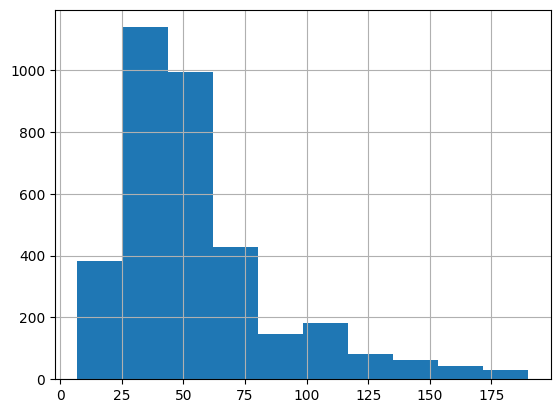

In [ ]:
df_train["time_of_follow_new"].hist()

In [ ]:
# 年収の特徴量作成
df_train['AnnualIncome'] = df_train['MonthlyIncome_0_med'] * 12
df_train['AnnualIncome_rounded'] = (df_train['AnnualIncome'] / 10000).round().astype(int)

# df_testへの適用
df_test['AnnualIncome'] = df_test['MonthlyIncome_0_med'] * 12
df_test['AnnualIncome_rounded'] = (df_test['AnnualIncome'] / 10000).round().astype(int)


print(df_train[['MonthlyIncome_0_med', 'AnnualIncome', 'AnnualIncome_rounded']].head())
print(df_test[['MonthlyIncome_0_med', 'AnnualIncome', 'AnnualIncome_rounded']].head())

   MonthlyIncome_0_med  AnnualIncome  AnnualIncome_rounded
0             254000.0     3048000.0                   305
1             404000.0     4848000.0                   485
2             278000.0     3336000.0                   334
3             327000.0     3924000.0                   392
4             258000.0     3096000.0                   310
   MonthlyIncome_0_med  AnnualIncome  AnnualIncome_rounded
0             497000.0     5964000.0                   596
1             300000.0     3600000.0                   360
2             260000.0     3120000.0                   312
3             260000.0     3120000.0                   312
4             269000.0     3228000.0                   323


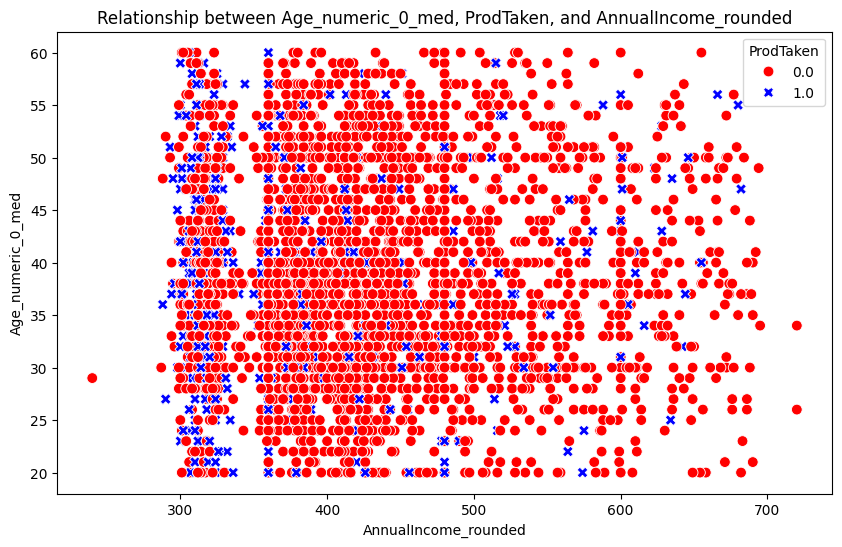

In [ ]:
# 散布図を作成:年収300万円台に正例が多い
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AnnualIncome_rounded', y='Age_numeric_0_med', hue='ProdTaken', style='ProdTaken', data=df_train, palette=['red', 'blue'], s=60)
plt.title('Relationship between Age_numeric_0_med, ProdTaken, and AnnualIncome_rounded')
plt.xlabel('AnnualIncome_rounded')
plt.ylabel('Age_numeric_0_med')
plt.legend(title='ProdTaken')
plt.show()

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 63 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       3489 non-null   int64   
 1   Age                      3489 non-null   category
 2   TypeofContact            3483 non-null   category
 3   CityTier                 3489 non-null   int64   
 4   DurationOfPitch          3489 non-null   category
 5   Occupation               3489 non-null   category
 6   Gender                   3489 non-null   category
 7   NumberOfPersonVisiting   3489 non-null   float64 
 8   NumberOfFollowups        3456 non-null   float64 
 9   ProductPitched           3489 non-null   category
 10  PreferredPropertyStar    3489 non-null   float64 
 11  NumberOfTrips            3489 non-null   category
 12  Passport                 3489 non-null   int64   
 13  PitchSatisfactionScore   3489 non-null   int64   
 14  Designat

In [ ]:
df_train["family"].isna().sum()

0

In [ ]:
# df_trainへの適用
df_train["MonthlyInc_fam"] = (df_train["MonthlyIncome_0_med"] / df_train["family"]).astype('int64')
df_train["AnnualInc_fam_round"] = (df_train["AnnualIncome_rounded"] / df_train["family"]).astype('int64')

# df_testへの適用
df_test["MonthlyInc_fam"] = (df_test["MonthlyIncome_0_med"] / df_test["family"]).astype('int64')
df_test["AnnualInc_fam_round"] = (df_test["AnnualIncome_rounded"] / df_test["family"]).astype('int64')

#
display(df_train[["MonthlyInc_fam", "AnnualInc_fam_round", "family"]].sample(n=10))

,MonthlyInc_fam,AnnualInc_fam_round,family
2891,113666,136,3
1150,325000,390,1
2380,185333,222,3
2008,130000,156,2
1874,104000,124,3
1903,175500,210,2
2691,142000,170,3
1737,103666,124,3
91,256000,307,1
3196,130666,156,3


In [ ]:
# df_trainへの適用
df_train["CityTier_reverse"] = df_train["CityTier"].replace({1: 3, 3: 1})

# df_testへの適用
df_test["CityTier_reverse"] = df_test["CityTier"].replace({1: 3, 3: 1})

#
print(df_train[["CityTier", "CityTier_reverse"]].head())

   CityTier  CityTier_reverse
0         2                 2
1         1                 3
2         1                 3
3         2                 2
4         3                 1


In [ ]:
# df_trainへの適用
df_train["Age_Trips"] = df_train["Age_numeric_0_med"] * df_train["NumberOfTrips_year"]

# df_testへの適用
df_test["Age_Trips"] = df_test["Age_numeric_0_med"] * df_test["NumberOfTrips_year"]


print(df_train["Age_Trips"].value_counts())

Age_Trips
60.0     100
90.0      90
80.0      74
150.0     70
114.0     66
        ... 
258.0      1
368.0      1
424.0      1
392.0      1
456.0      1
Name: count, Length: 209, dtype: int64


In [ ]:
#年間旅行人数/年齢 ＝年齢に対する旅行頻度
df_train["travel_frequency"] = np.where(df_train["NumberOfTrips_year"] != 0,
                                         df_train["Age_numeric_0_med"] / df_train["NumberOfTrips_year"],
                                         df_train["Age_numeric_0_med"])

# df_testへの適用
df_test["travel_frequency"] = np.where(df_test["NumberOfTrips_year"] != 0,
                                         df_test["Age_numeric_0_med"] / df_test["NumberOfTrips_year"],
                                         df_test["Age_numeric_0_med"])


print(df_train["travel_frequency"].value_counts())

travel_frequency
10.000000    117
15.000000     97
20.000000     83
18.000000     69
19.000000     68
            ... 
2.500000       1
3.500000       1
9.833333       1
7.166667       1
7.125000       1
Name: count, Length: 222, dtype: int64


In [ ]:
#掛け合わせる＝各クラスごとの世帯年収＝余裕度
df_train["Designation_Annual"] = df_train["Designation_rank"].astype(int) * df_train["AnnualInc_fam_round"]

# df_testへの適用
df_test["Designation_Annual"] = df_test["Designation_rank"].astype(int) * df_test["AnnualInc_fam_round"]

#
print(df_train[["Designation_rank", "AnnualInc_fam_round", "Designation_Annual"]].head())

  Designation_rank  AnnualInc_fam_round  Designation_Annual
0                3                  305                 915
1                2                  485                 970
2                3                  167                 501
3                2                  392                 784
4                3                  310                 930


In [ ]:
#世帯月収でも一応作成
df_train["Designation_Month"] = df_train["Designation_rank"].astype(int) * df_train["MonthlyInc_fam"]

# df_testへの適用
df_test["Designation_Month"] = df_test["Designation_rank"].astype(int) * df_test["MonthlyInc_fam"]

#
print(df_train[["Designation_rank", "MonthlyInc_fam", "Designation_Month"]].head())

  Designation_rank  MonthlyInc_fam  Designation_Month
0                3          254000             762000
1                2          404000             808000
2                3          139000             417000
3                2          327000             654000
4                3          258000             774000


In [ ]:
# 旅行間隔を計算する関数
def calc_travel_interval(trips_per_year):
  if pd.isna(trips_per_year):
    return np.nan
  elif trips_per_year == 0:
    return 0  # 旅行回数が0回の場合は旅行間隔を0とする
  else:
    return 12 / trips_per_year

# df_trainへの適用
df_train['Travel_Interval'] = df_train['NumberOfTrips_year'].apply(calc_travel_interval).astype(int)

# df_testへの適用
df_test['Travel_Interval'] = df_test['NumberOfTrips_year'].apply(calc_travel_interval).astype(int)

print(df_train['Travel_Interval'].value_counts())

Travel_Interval
6     1164
4      820
2      645
12     409
1      266
3      163
0       22
Name: count, dtype: int64


In [ ]:
#年齢＊世帯収入
df_train["Age_Annual"] = df_train["AnnualIncome_rounded"] * df_train["Age_numeric_0_med"].astype(int)

# df_testへの適用
df_test["Age_Annual"] = df_test["AnnualIncome_rounded"] * df_test["Age_numeric_0_med"].astype(int)

print(df_train["Age_Annual"].value_counts())

Age_Annual
10800    26
14400    17
18240    15
11520    14
16200    12
         ..
16974     1
9044      1
12616     1
17682     1
14696     1
Name: count, Length: 2184, dtype: int64


In [ ]:
df_test['MonthlyIncome_0_med'].describe()

,MonthlyIncome_0_med
count,3489.000000
mean,356400.687876
std,76592.354156
min,200000.000000
25%,300000.000000
50%,342000.000000
75%,400000.000000
max,600000.000000


In [ ]:
# 年齢層を定義
age_bins = [0, 29, 39, 49, 59, float('inf')]
age_labels = ['20s', '30s', '40s', '50s', '60s_over']
income_bins = np.arange(0, df_train['MonthlyIncome_0_med'].max() + 50000, 50000)


# 年齢層別・月収帯別偏差値を算出する関数を定義
def calculate_age_income_zscore(row, stats):
    age_income_group = row['age_income_group']
    monthly_income = row['MonthlyIncome_0_med']

    if age_income_group in stats.index:
        mean = stats.loc[age_income_group, 'mean']
        std = stats.loc[age_income_group, 'std']

        if std == 0:
            return 0  # 標準偏差が0の場合は偏差値を0とする
        else:
            return (monthly_income - mean) / std  # 偏差値を計算
    else:
        median_zscore = stats['zscore'].median()  # stats DataFrame から zscore の中央値を取得
        return median_zscore

# 'age_income_group' カラムを作成
df_train['age_group'] = pd.cut(df_train['Age_numeric_0_med'], bins=age_bins, labels=age_labels, include_lowest=True, duplicates='drop')
df_train['income_group'] = pd.cut(df_train['MonthlyIncome_0_med'], bins=income_bins, labels=False, include_lowest=True, duplicates='drop')
df_train['age_income_group'] = df_train['age_group'].astype(str) + '_' + df_train['income_group'].astype(str)

df_test['age_group'] = pd.cut(df_test['Age_numeric_0_med'], bins=age_bins, labels=age_labels, include_lowest=True, duplicates='drop')
df_test['income_group'] = pd.cut(df_test['MonthlyIncome_0_med'], bins=income_bins, labels=False, include_lowest=True, duplicates='drop')
df_test['age_income_group'] = df_test['age_group'].astype(str) + '_' + df_test['income_group'].astype(str)


# stats DataFrame の作成
stats = df_train.groupby('age_income_group')['MonthlyIncome_0_med'].agg(['mean', 'std'])
stats['zscore'] = stats.apply(lambda row: 0 if row['std'] == 0 else (df_train['MonthlyIncome_0_med'].median() - row['mean']) / row['std'], axis=1)  # zscore カラムを初期化、中央値で埋める

# stats DataFrame の作成
stats = df_train.groupby('age_income_group')['MonthlyIncome_0_med'].agg(['mean', 'std'])
stats['zscore'] = stats.apply(lambda row: 0 if row['std'] == 0 else (df_train['MonthlyIncome_0_med'].median() - row['mean']) / row['std'], axis=1) # zscore カラムを初期化、中央値で埋める


# 年齢層別・月収帯別偏差値を算出し、新しいカラムに追加
df_train['income_zscore_by_age'] = df_train.apply(calculate_age_income_zscore, args=(stats,), axis=1)

# df_test にも偏差値を計算し、'income_zscore_by_age' カラム追加
df_test['income_zscore_by_age'] = df_test.apply(calculate_age_income_zscore, args=(stats,), axis=1)

#
print(df_train[['age_income_group', 'MonthlyIncome_0_med', 'income_zscore_by_age']].head())

  age_income_group  MonthlyIncome_0_med  income_zscore_by_age
0            40s_5             254000.0             -1.197206
1            30s_8             404000.0             -1.470061
2            20s_5             278000.0              0.256426
3            20s_6             327000.0             -0.032776
4            40s_5             258000.0             -0.964625


In [ ]:
print(df_train[['Age_numeric_0_med', 'MonthlyIncome_0_med', 'income_zscore_by_age']].head())

   Age_numeric_0_med  MonthlyIncome_0_med  income_zscore_by_age
0               48.0             254000.0             -1.197206
1               30.0             404000.0             -1.470061
2               25.0             278000.0              0.256426
3               21.0             327000.0             -0.032776
4               41.0             258000.0             -0.964625


In [ ]:
#income_zscore_by_ageの平均値を計算して0補完
mean_zscore = df_train["income_zscore_by_age"].mean()


df_train["income_zscore_by_age"] = df_train["income_zscore_by_age"].replace(0, mean_zscore)

# df_test に適用
df_test["income_zscore_by_age"] = df_test["income_zscore_by_age"].replace(0, mean_zscore)


print(df_train["income_zscore_by_age"].value_counts())

income_zscore_by_age
 1.460466    76
 1.477483    54
 1.543817    50
 1.362403    39
 1.421970    36
             ..
-0.514836     1
-0.090016     1
-0.197167     1
-1.783337     1
 0.153039     1
Name: count, Length: 994, dtype: int64


In [ ]:
#顧客のランクと商品ランクに基づく営業満足度
df_train["Rank_Pitch"] = df_train['ProductPitched_Score'] * df_train['Designation_rank'].astype(int)

# df_testへの適用
df_test["Rank_Pitch"] = df_test['ProductPitched_Score'] * df_test['Designation_rank'].astype(int)


print(df_train["Rank_Pitch"].value_counts())

Rank_Pitch
3     2152
4      826
16     298
20     113
2       24
6       19
8       18
1       11
12      10
10       8
9        5
15       4
5        1
Name: count, dtype: int64


In [ ]:
# 年齢別ステータス
df_train["Status_of_age"] = (df_train["child_info_int"] + df_train["material_score"] + df_train["car_status_count"]) / df_train["Age_numeric_0_med"]
df_train["Status_of_age"] = df_train["Status_of_age"].astype(float)

# df_testへの適用
df_test["Status_of_age"] = (df_test["child_info_int"] + df_test["material_score"] + df_test["car_status_count"]) / df_test["Age_numeric_0_med"]
df_test["Status_of_age"] = df_test["Status_of_age"].astype(float)


#
print(df_train["Status_of_age"].value_counts())

Status_of_age
0.100000    118
0.125000     84
0.090909     77
0.133333     72
0.066667     71
           ... 
0.300000      1
0.175000      1
0.020408      1
0.304348      1
0.240000      1
Name: count, Length: 193, dtype: int64


In [ ]:
#結婚有無+車有無+子供人数+一緒に旅行を計画している人＊年間旅行回数
#→ユーザーのステータスと旅行頻度の関係の強調
df_train["Status_of_travel"] = (df_train["child_info_int"] + df_train["material_score"] + df_train["car_status_count"]) * df_train["NumberOfTrips_year"]
df_train["Status_of_travel"] = df_train["Status_of_travel"].astype(int)

# df_testへの適用
df_test["Status_of_travel"] = (df_test["child_info_int"] + df_test["material_score"] + df_test["car_status_count"]) * df_test["NumberOfTrips_year"]
df_test["Status_of_travel"] = df_test["Status_of_travel"].astype(int)

#
print(df_train["Status_of_travel"].value_counts())

Status_of_travel
6     481
12    351
4     348
8     336
15    266
10    264
20    188
9     184
2     169
3     129
25    107
5      90
18     79
30     72
21     72
28     67
14     50
24     45
16     44
35     41
1      36
0      22
42     19
7      11
36      8
49      5
32      3
48      1
40      1
Name: count, dtype: int64


<Axes: >

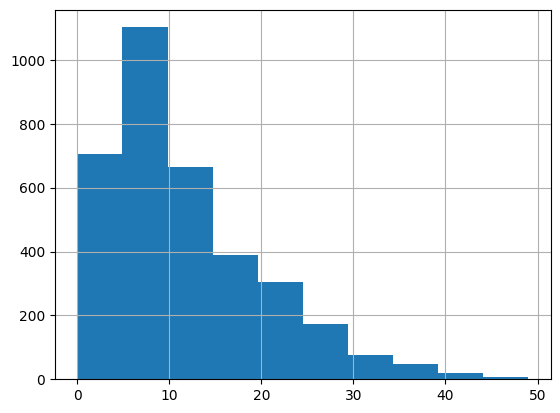

In [ ]:
df_train["Status_of_travel"].hist()

In [ ]:
# 意味合いに沿ってrank化
rank_dict = {
    'Large Business': 3,
    'Small Business': 2,
    'Salaried': 1,
}

# df_trainへの適用
df_train['Occupation_rank'] = df_train['Occupation'].map(rank_dict).astype(int)

# df_testへの適用
df_test['Occupation_rank'] = df_test['Occupation'].map(rank_dict).astype(int)

print(df_train["Occupation_rank"].value_counts())

Occupation_rank
2    1727
1    1401
3     361
Name: count, dtype: int64


In [ ]:
#職業ランク×都市ランク=収入が高い人は都市近郊（一つの経済指標）
df_train["JobCityRank"] = df_train["Occupation_rank"] * df_train["CityTier_reverse"]

# df_testへの適用
df_test["JobCityRank"] = df_test["Occupation_rank"] * df_test["CityTier_reverse"]


print(df_train["JobCityRank"].value_counts())

JobCityRank
2    859
4    842
6    780
3    636
9    210
1    162
Name: count, dtype: int64


In [ ]:
#Occupation_rankの各値に対するCityTier_reverseの出現回数を計算
citytier_reverse_counts = df_train.groupby("Occupation_rank")["CityTier_reverse"].value_counts().to_dict()

# 新しい特徴量を作成
df_train["City_freq_Occupation"] = df_train.apply(
    lambda row: citytier_reverse_counts.get((row["Occupation_rank"], row["CityTier_reverse"]), 0),
    axis=1,
)
df_test["City_freq_Occupation"] = df_test.apply(
    lambda row: citytier_reverse_counts.get((row["Occupation_rank"], row["CityTier_reverse"]), 0),
    axis=1,
)

print(df_train[["Occupation_rank", "CityTier_reverse", "City_freq_Occupation"]].head())


   Occupation_rank  CityTier_reverse  City_freq_Occupation
0                3                 2                   121
1                1                 3                   606
2                3                 3                   210
3                2                 2                   842
4                2                 1                   226


In [ ]:
#旅行を予定している人数が多いほど売り込み満足度のスコアが高いのでは
df_train["GroupTravel_Satisfaction"] = df_train["PitchSatisfactionScore"] * df_train["NumberOfPersonVisiting"]
df_train["GroupTravel_Satisfaction"] = df_train["GroupTravel_Satisfaction"].astype(int)

# df_testへの適用
df_test["GroupTravel_Satisfaction"] = df_test["PitchSatisfactionScore"] * df_test["NumberOfPersonVisiting"]
df_test["GroupTravel_Satisfaction"] = df_test["GroupTravel_Satisfaction"].astype(int)

print(df_train["GroupTravel_Satisfaction"].value_counts())

GroupTravel_Satisfaction
6     849
4     680
2     435
8     417
3     349
12    289
9     270
1      56
10     44
15     42
16     41
5      12
20      5
Name: count, dtype: int64


<Axes: >

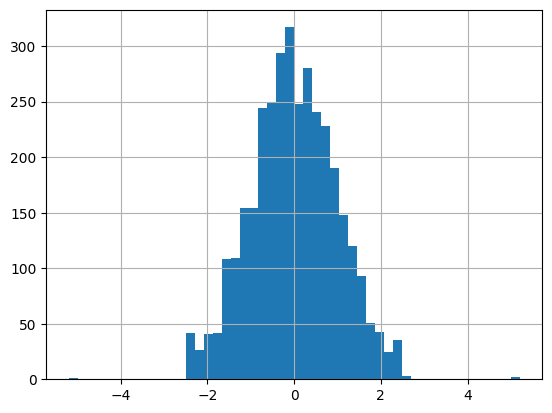

In [ ]:
from sklearn.preprocessing import QuantileTransformer

# RANKGAUSSオブジェクトの作成
qt = QuantileTransformer(n_quantiles=100, random_state=123, output_distribution='normal')

# df_trainへの適用
income_data_train = df_train[["MonthlyIncome_0_med"]]
qt.fit(income_data_train)  # df_trainのデータでfit
df_train["M_income_transformed"] = qt.transform(income_data_train)

# df_testへの適用
income_data_test = df_test[["MonthlyIncome_0_med"]]
df_test["M_income_transformed"] = qt.transform(income_data_test)  # df_testのデータを変換

df_train["M_income_transformed"].hist(bins=50)

<Axes: >

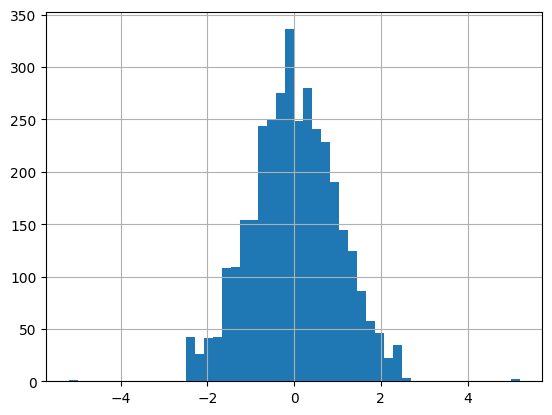

In [ ]:
# RANKGAUSSオブジェクトの作成
qt = QuantileTransformer(n_quantiles=100, random_state=123, output_distribution='normal')

# 年収でも作成しておく
income_data_train = df_train[["AnnualIncome_rounded"]]
qt.fit(income_data_train)  # df_trainのデータでfit
df_train["A_income_transformed"] = qt.transform(income_data_train)

# df_testへの適用
income_data_test = df_test[["AnnualIncome_rounded"]]
df_test["A_income_transformed"] = qt.transform(income_data_test)  # df_testのデータを変換

#
df_train["A_income_transformed"].hist(bins=50)

<Axes: >

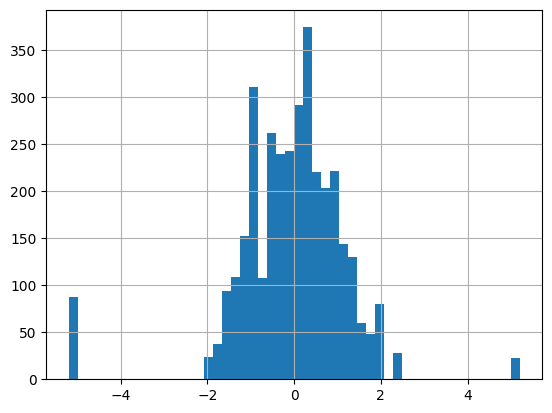

In [ ]:
# RANKGAUSSオブジェクトの作成
qt = QuantileTransformer(n_quantiles=100, random_state=123, output_distribution='normal')

# df_trainへの適用
income_data_train = df_train[["Age_numeric_0_med"]]
qt.fit(income_data_train)  # df_trainのデータでfit
df_train["Age_nume_transformed"] = qt.transform(income_data_train)

# df_testへの適用
income_data_test = df_test[["Age_numeric_0_med"]]
df_test["Age_nume_transformed"] = qt.transform(income_data_test)  # df_testのデータを変換

#
df_train["Age_nume_transformed"].hist(bins=50)

<Axes: >

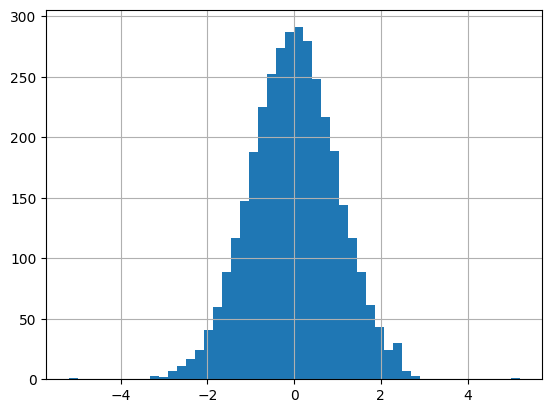

In [ ]:
# RANKGAUSSオブジェクトの作成
qt = QuantileTransformer(n_quantiles=100, random_state=123, output_distribution='normal')

# df_trainへの適用
income_data_train = df_train[["Age_Annual"]]
qt.fit(income_data_train)
df_train["Age_ann_transformed"] = qt.transform(income_data_train)

# df_testへの適用
income_data_test = df_test[["Age_Annual"]]
df_test["Age_ann_transformed"] = qt.transform(income_data_test)

#
df_train["Age_ann_transformed"].hist(bins=50)

<Axes: >

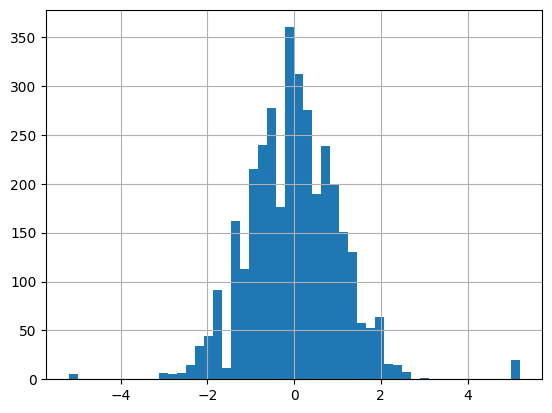

In [ ]:
# RANKGAUSSオブジェクトの作成
qt = QuantileTransformer(n_quantiles=100, random_state=123, output_distribution='normal')

# df_trainへの適用
income_data_train = df_train[["time_of_follow_new"]]
qt.fit(income_data_train)
df_train["time_of_transformed"] = qt.transform(income_data_train)

# df_testへの適用
income_data_test = df_test[["time_of_follow_new"]]
df_test["time_of_transformed"] = qt.transform(income_data_test)

#
df_train["time_of_transformed"].hist(bins=50)

In [ ]:
df_train["time_of_transformed"].describe()

,time_of_transformed
count,3489.000000
mean,0.009761
std,1.064442
min,-5.199338
25%,-0.666564
50%,-0.050661
75%,0.650837
max,5.199338


In [ ]:
# ホテルの評価*家族構成人数
df_train["family"] = df_train["family"].astype(int)
df_train["family_hotel_score"] = df_train["PreferredPropertyStar"] * df_train["family"]
df_train["family_hotel_score"] = df_train["family_hotel_score"].astype(int)

# df_testへの適用
df_test["family"] = df_test["family"].astype(int)
df_test["family_hotel_score"] = df_test["PreferredPropertyStar"] * df_test["family"]
df_test["family_hotel_score"] = df_test["family_hotel_score"].astype(int)

print(df_train["family_hotel_score"].value_counts())

family_hotel_score
6     782
9     736
12    566
8     389
3     374
4     291
16    125
15     92
10     64
20     41
5      25
25      4
Name: count, dtype: int64


In [ ]:
# 各年齢あたりの年収
df_train["Annual_Age"] = df_train["AnnualIncome_rounded"] / df_train["Age_numeric_0_med"].astype(int)

# df_testへの適用
df_test["Annual_Age"] = df_test["AnnualIncome_rounded"] / df_test["Age_numeric_0_med"].astype(int)


print(df_train["Annual_Age"].value_counts())

Annual_Age
12.000000    44
10.000000    21
8.000000     17
15.000000    17
9.000000     14
             ..
6.450980      1
12.722222     1
13.187500     1
9.122807      1
7.590909      1
Name: count, Length: 2328, dtype: int64


In [ ]:
# 各顧客ランクあたりの年収
df_train['income_Degi_rank'] = df_train['AnnualIncome_rounded'] / df_train['Designation_rank'].astype(int)

# df_testへの適用
df_test['income_Degi_rank'] = df_test['AnnualIncome_rounded'] / df_test['Designation_rank'].astype(int)

#
print(df_train['income_Degi_rank'].value_counts())

income_Degi_rank
120.000000    113
360.000000     81
240.000000     72
104.000000     46
137.333333     37
             ... 
144.500000      1
127.750000      1
159.666667      1
157.333333      1
158.500000      1
Name: count, Length: 708, dtype: int64


In [ ]:
# 年収/顧客への売り込み時間
df_train['Anual_div_pitch_time'] = df_train['AnnualIncome_rounded'] / df_train['Pitch_minutes_0_med'].replace(0, 1)

# df_testへの適用
df_test['Anual_div_pitch_time'] = df_test['AnnualIncome_rounded'] / df_test['Pitch_minutes_0_med'].replace(0, 1)

#
print(df_train['Anual_div_pitch_time'].value_counts())

Anual_div_pitch_time
40.000000    36
30.000000    27
32.000000    24
36.000000    21
45.000000    20
             ..
37.833333     1
19.833333     1
19.285714     1
22.222222     1
37.111111     1
Name: count, Length: 1928, dtype: int64


<Axes: >

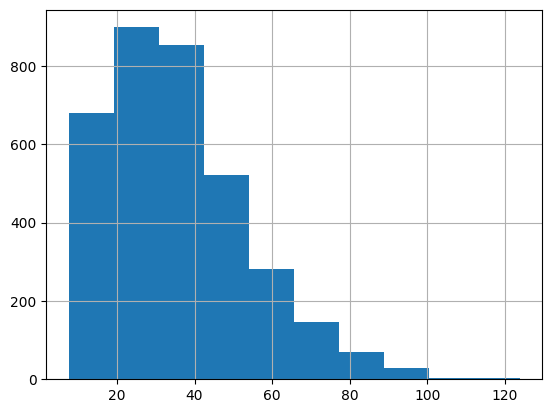

In [ ]:
df_train['Anual_div_pitch_time'].hist()

In [ ]:
# 総合的な営業力
df_train["total_pitch_point"] = df_train["NumberOfFollowups_max"] * (df_train["PitchSatisfactionScore"] + df_train["ProductPitched_Score"] + df_train["Pitch_minutes_0_med"])

# df_testへの適用
df_test["total_pitch_point"] = df_test["NumberOfFollowups_max"] * (df_test["PitchSatisfactionScore"] + df_test["ProductPitched_Score"] + df_test["Pitch_minutes_0_med"])

#
print(df_train["total_pitch_point"].value_counts())

total_pitch_point
60.0     221
48.0     169
80.0     141
72.0     132
56.0     126
        ... 
186.0      1
216.0      1
174.0      1
82.0       1
23.0       1
Name: count, Length: 123, dtype: int64


<Axes: >

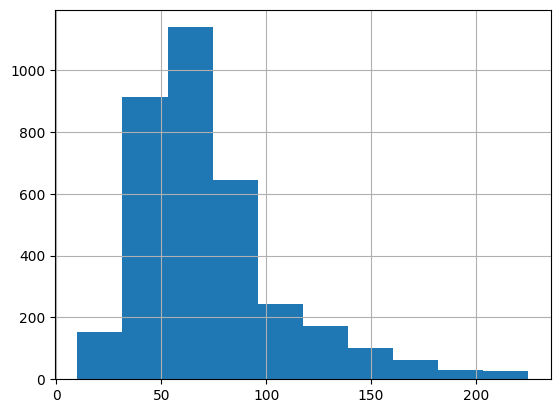

In [ ]:
df_train["total_pitch_point"].hist()

<Axes: >

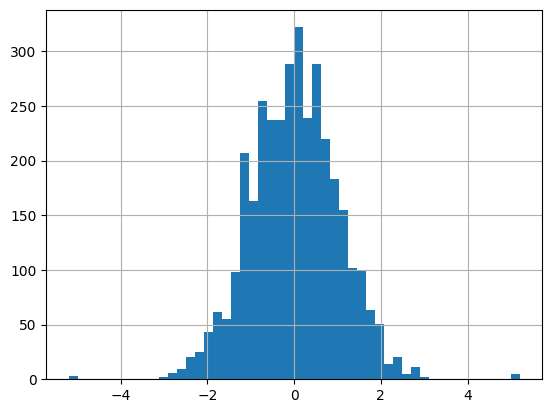

In [ ]:
# RANKGAUSSオブジェクトの作成
qt = QuantileTransformer(n_quantiles=100, random_state=123, output_distribution='normal')

# df_trainへの適用
income_data_train = df_train[["total_pitch_point"]]
qt.fit(income_data_train)  # df_trainのデータでfit
df_train["total_pitch_transformed"] = qt.transform(income_data_train)

# df_testへの適用
income_data_test = df_test[["total_pitch_point"]]
df_test["total_pitch_transformed"] = qt.transform(income_data_test)  # df_testのデータを変換

#
df_train["total_pitch_transformed"].hist(bins=50)

In [ ]:
# 売り込み満足度*顧客ランク=満足度と顧客ランクが高いほど成約率も高いのでは
df_train["RankSatisfaction"] = df_train["PitchSatisfactionScore"] * df_train["Designation_rank"].astype(int)

# df_testへの適用
df_test["RankSatisfaction"] = df_test["PitchSatisfactionScore"] * df_test["Designation_rank"].astype(int)

#
print(df_train["RankSatisfaction"].value_counts())

RankSatisfaction
4     664
2     632
6     580
12    362
3     351
8     275
9     263
1     189
16     70
20     33
10     26
15     23
5      21
Name: count, dtype: int64


In [ ]:
# 売り込み満足度*年収=高い数値になほど成約しやすいのでは
df_train["Annual_satis_score"] = df_train["PitchSatisfactionScore"] * df_train["AnnualIncome_rounded"]

# df_testへの適用
df_test["Annual_satis_score"] = df_test["PitchSatisfactionScore"] * df_test["AnnualIncome_rounded"]

#
print(df_train["Annual_satis_score"].value_counts())

Annual_satis_score
1440    81
720     69
960     44
1080    42
1648    38
        ..
353      1
1340     1
330      1
1707     1
334      1
Name: count, Length: 920, dtype: int64


<Axes: >

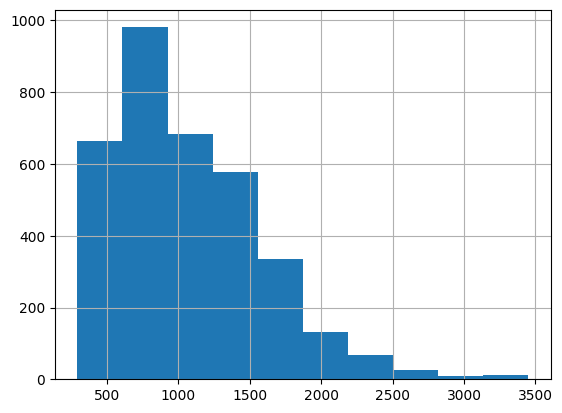

In [ ]:
df_train["Annual_satis_score"].hist()

<Axes: >

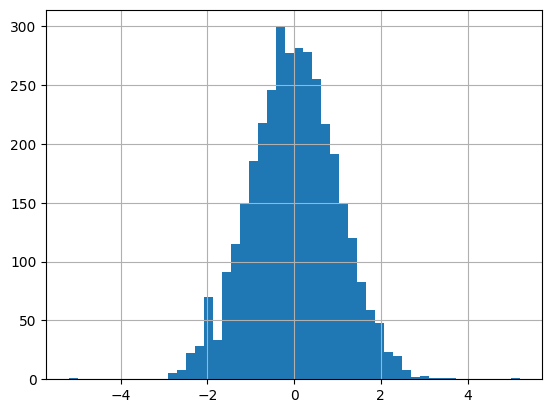

In [ ]:
# RANKGAUSSオブジェクトの作成
qt = QuantileTransformer(n_quantiles=100, random_state=123, output_distribution='normal')

# df_trainへの適用
income_data_train = df_train[["Annual_satis_score"]]
qt.fit(income_data_train)  # df_trainのデータでfit
df_train["Annual_satis_transformed"] = qt.transform(income_data_train)

# df_testへの適用
income_data_test = df_test[["Annual_satis_score"]]
df_test["Annual_satis_transformed"] = qt.transform(income_data_test)  # df_testのデータを変換

#
df_train["Annual_satis_transformed"].hist(bins=50)

In [ ]:
df_train["Age_numeric_0_med"].describe()

,Age_numeric_0_med
count,3489.000000
mean,38.715391
std,9.818951
min,20.000000
25%,31.000000
50%,38.000000
75%,46.000000
max,60.000000


In [ ]:
df_train.isnull().sum()

,0
id,0
Age,0
TypeofContact,6
CityTier,0
DurationOfPitch,0
...,...
total_pitch_point,0
total_pitch_transformed,0
RankSatisfaction,0
Annual_satis_score,0


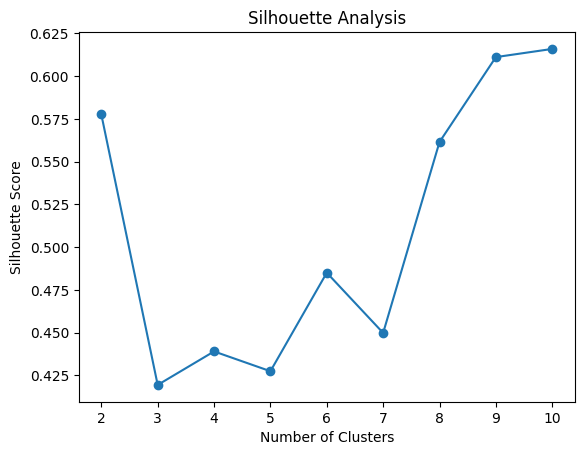

In [ ]:
#クラスタリングできそうな関係性を見つける
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# クラスタ数を変化させながら、シルエット係数を計算し確認
silhouette_scores = []
for i in range(2, 11): # クラスタ数は2以上でないと計算できない
    kmeans = KMeans(n_clusters=i, random_state=123)
    labels = kmeans.fit_predict(df_train[[
       "PitchSatisfactionScore",
            "ProductPitched_Score","Passport", "RankSatisfaction",]])
    silhouette_scores.append(silhouette_score(df_train[["PitchSatisfactionScore",
            "ProductPitched_Score","Passport", "RankSatisfaction",]], labels))

# シルエット係数をグラフ化
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

In [ ]:
# クラスタリングに用いる特徴量を選択
features = ["PitchSatisfactionScore",
            "ProductPitched_Score","Passport", "RankSatisfaction"]

# 特徴量を標準化
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_train[features])

# KMeansでクラスタリング (クラスタ数を5に設定)
kmeans = KMeans(n_clusters=10, random_state=123)
df_train['cluster_test'] = kmeans.fit_predict(scaled_features)

# シルエット係数を計算
silhouette_avg = silhouette_score(scaled_features, df_train['cluster_test'])
print(f"Silhouette Score: {silhouette_avg}")

# クラスタごとの特徴量の平均値を表示
cluster_means = df_train.groupby('cluster_test')[features].mean()
print(cluster_means)

# テストデータにも同様の処理を適用
scaled_features_test = scaler.transform(df_test[features]) # fit_transform ではなく transform を使用
df_test['cluster_test'] = kmeans.predict(scaled_features_test)

Silhouette Score: 0.5658212555058868
              PitchSatisfactionScore  ProductPitched_Score  Passport  \
cluster_test                                                           
0                           2.345088              2.000000  0.000000   
1                           3.718894              1.213518  0.000000   
2                           2.324324              3.378378  1.000000   
3                           1.000000              1.603448  0.000000   
4                           2.237885              4.286344  0.000000   
5                           3.649289              3.011848  0.000000   
6                           2.422414              1.452586  1.000000   
7                           4.333333              4.428571  0.142857   
8                           2.008000              1.000000  0.000000   
9                           1.602254              3.133655  0.000000   

              RankSatisfaction  
cluster_test                    
0                     4.715365  

In [ ]:
df_train['cluster_test'].value_counts()

,count
cluster_test,
1,651
9,621
5,422
0,397
8,375
3,348
6,232
4,227
2,111


In [ ]:
#ここまで特徴量作成
df_train2 = df_train.copy()#lgbm用にコピー
df_test2 = df_test.copy()#lgbm用にコピー

In [ ]:
#カテゴリ型に変換するカラムのリスト
category_cols =["TypeofContact_binary","TypeofContact_oe","CityTier_reverse","Gender_0","Passport", "material_count","PreferredPropertyStar",
                "car_status_count","child_info_cat",'MonthlyIncome_binned','Age_numeric_binned',"Occupation_oe",'cluster_test']




# カテゴリ型に変換
df_train2[category_cols] = df_train2[category_cols].astype('category')
df_test2[category_cols] = df_test2[category_cols].astype('category')

In [ ]:
x_train2 = df_train2.drop(columns = ["ProdTaken", "id"])
y_train  = df_train2["ProdTaken"]
id_train = df_train2["id"]

In [ ]:
print("mean: {:.4f}".format(y_train.mean()))
y_train.value_counts()

mean: 0.1424


,count
ProdTaken,
0.0,2992
1.0,497


In [ ]:
cv = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(x_train2, y_train))

print("index(train):", cv[0][0])
print("index(valid):", cv[0][1])

index(train): [   1    2    3 ... 3484 3485 3487]
index(valid): [   0    4    7    8   22   25   40   45   46   50   51   54   59   60
   61   66   69   71   73   75   88   93   97  105  107  109  124  134
  135  138  144  149  158  161  162  174  177  184  187  191  198  202
  205  214  218  220  228  244  252  259  260  262  268  269  272  275
  286  292  302  304  310  317  320  330  345  366  371  376  380  386
  394  400  431  432  435  436  450  456  458  463  469  472  473  475
  478  484  514  524  529  534  536  537  540  545  547  557  561  579
  583  591  597  600  601  604  613  615  621  628  630  634  641  642
  644  647  654  667  671  679  684  692  693  695  697  701  715  722
  724  726  730  741  742  745  747  752  757  762  763  775  778  785
  786  790  795  796  799  835  836  841  844  846  856  857  859  863
  864  868  874  876  877  878  881  882  888  890  893  899  907  917
  930  938  939  941  952  954  955  959  960  973  974  978  980  984
  990  991  9

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 98 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   id                        3489 non-null   int64   
 1   Age                       3489 non-null   category
 2   TypeofContact             3483 non-null   category
 3   CityTier                  3489 non-null   int64   
 4   DurationOfPitch           3489 non-null   category
 5   Occupation                3489 non-null   category
 6   Gender                    3489 non-null   category
 7   NumberOfPersonVisiting    3489 non-null   float64 
 8   NumberOfFollowups         3456 non-null   float64 
 9   ProductPitched            3489 non-null   category
 10  PreferredPropertyStar     3489 non-null   float64 
 11  NumberOfTrips             3489 non-null   category
 12  Passport                  3489 non-null   int64   
 13  PitchSatisfactionScore    3489 non-null   int64 

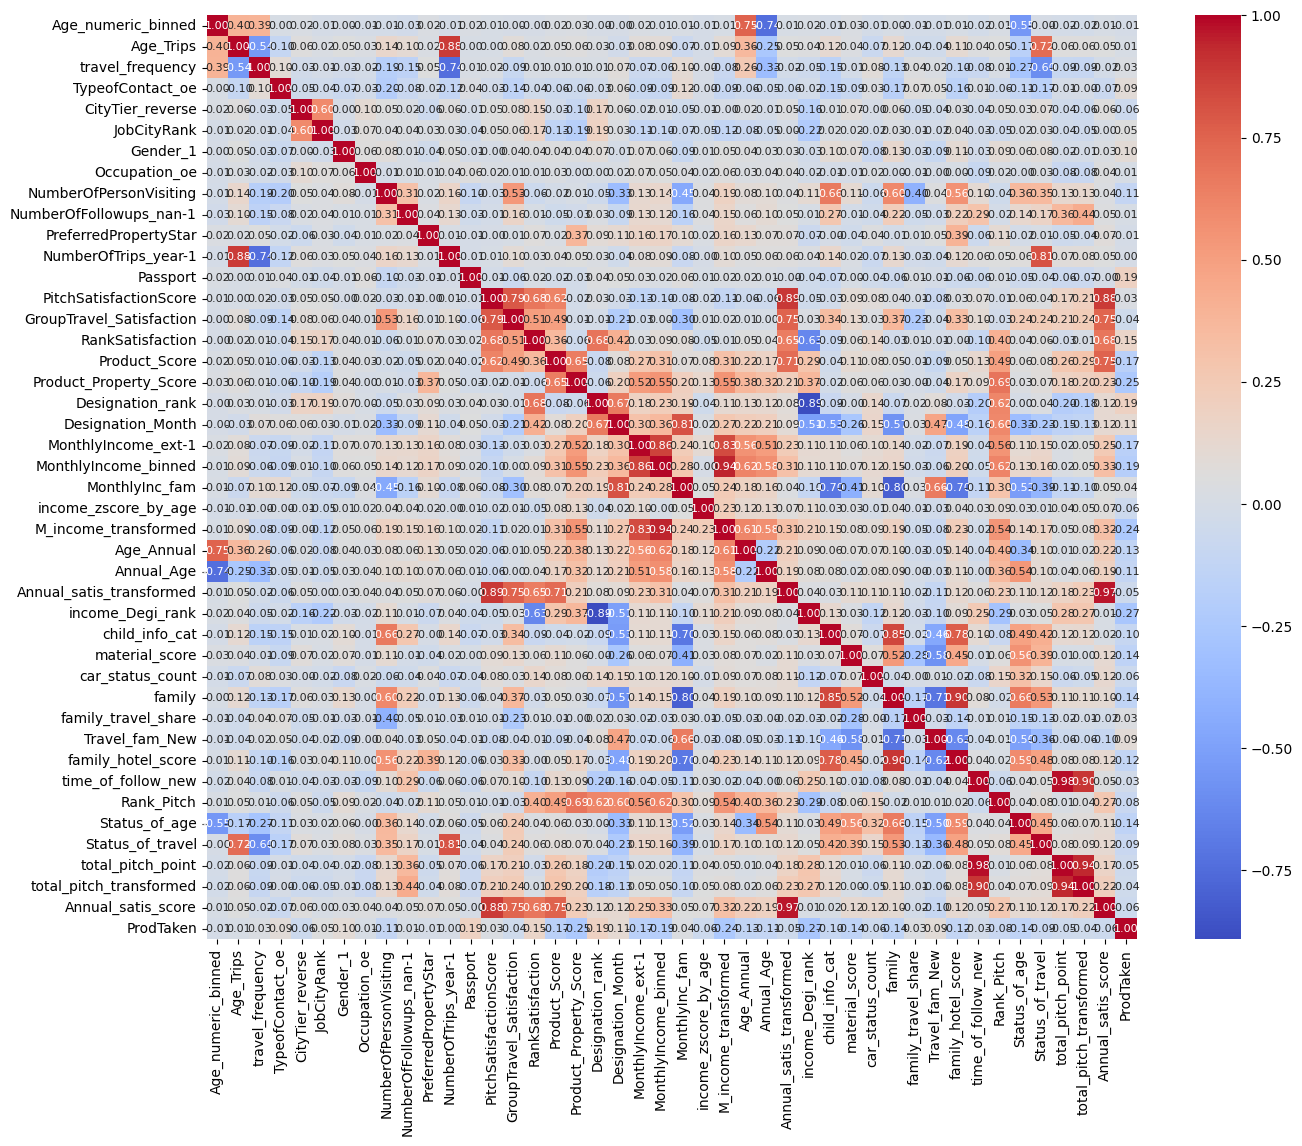

In [ ]:
selected_cols = ["Age_numeric_binned","Age_Trips","travel_frequency","TypeofContact_oe","CityTier_reverse",
                     "JobCityRank","Gender_1", "Occupation_oe", "NumberOfPersonVisiting", "NumberOfFollowups_nan-1", "PreferredPropertyStar",
                     "NumberOfTrips_year-1","Passport", "PitchSatisfactionScore",
                     "GroupTravel_Satisfaction", "RankSatisfaction", "Product_Score", "Product_Property_Score",
                     "Designation_rank", "Designation_Month","MonthlyIncome_ext-1", "MonthlyIncome_binned", "MonthlyInc_fam",
                     "income_zscore_by_age", "M_income_transformed", "Age_Annual", "Annual_Age","Annual_satis_transformed",
                     "income_Degi_rank","child_info_cat", "material_score", "car_status_count","family","family_travel_share",
                     "Travel_fam_New", "family_hotel_score", "time_of_follow_new", "Rank_Pitch", "Status_of_age", "Status_of_travel",
                      "total_pitch_point","total_pitch_transformed","Annual_satis_score","ProdTaken"]

# 選択したカラムで相関行列を計算
corr_matrix = df_train[selected_cols].corr()

plt.figure(figsize=(15, 12))  # サイズを大きく
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 8})
plt.show()


In [ ]:
 #ベースライン特徴量選択
x_train = x_train2[["Age_numeric_binned","Age_Trips","travel_frequency","TypeofContact_oe","CityTier_reverse",
                     "JobCityRank","Gender_1", "Occupation_oe", "NumberOfPersonVisiting", "NumberOfFollowups_nan-1", "PreferredPropertyStar",
                     "NumberOfTrips_year-1","Passport", "PitchSatisfactionScore",
                     "GroupTravel_Satisfaction", "RankSatisfaction", "Product_Score", "Product_Property_Score",
                     "Designation_rank", "Designation_Month","MonthlyIncome_ext-1", "MonthlyIncome_binned", "MonthlyInc_fam",
                     "income_zscore_by_age", "M_income_transformed", "Age_Annual", "Annual_Age","Annual_satis_transformed",
                     "income_Degi_rank","child_info_cat", "material_score", "car_status_count","family","family_travel_share",
                     "Travel_fam_New", "family_hotel_score", "time_of_follow_new", "Rank_Pitch", "Status_of_age", "Status_of_travel",
                      "total_pitch_point","total_pitch_transformed","Annual_satis_score",]]

In [ ]:
cv =  list(StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123).split(x_train, y_train))

nfold = 0
idx_tr, idx_va = cv[nfold][0], cv[nfold][1]

x_tr, y_tr, id_tr = x_train.loc[idx_tr, :], y_train[idx_tr], id_train[idx_tr]
x_va, y_va, id_va = x_train.loc[idx_va, :], y_train[idx_va], id_train[idx_va]

print(x_tr.shape, y_tr.shape, id_tr.shape)
print(x_va.shape, y_va.shape, id_va.shape)

(2791, 43) (2791,) (2791,)
(698, 43) (698,) (698,)


In [ ]:
# ベースラインパラメータの設定
params = {
"boosting_type" : "gbdt",
    "objective": "binary",
    "metric": "auc",
    "categorical_feature": ["TypeofContact_oe","Occupation_oe","CityTier_reverse","Gender_0","Passport","PreferredPropertyStar",
                "car_status_count","MonthlyIncome_binned","child_info_cat", "material_score",],
    "learning_rate": 1,
    "num_leaves": 64,
    'lambda_l1': 0.1,
    'lambda_l2': 20,
    "min_data_in_leaf": 50,
    "max_depth": 1,
    "n_estimators": 3000,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "subsample_freq": 2,
    "subsample": 0.7,
    "random_state": 123,
    "importance_type": "gain",
    "early_stopping_rounds": 100,
    "verbose": -1,
}

model_lgb_base = lgb.LGBMClassifier(**params)
model_lgb_base.fit(x_tr,y_tr,
          eval_set = [(x_tr, y_tr), (x_va, y_va)],)

with open("model_lgb_base_fold0.pickle", "wb") as f:
     pickle.dump(model_lgb_base, f, protocol=4)

In [ ]:
x_tr_pred = model_lgb_base.predict_proba(x_tr)[:,1]
metric_tr = roc_auc_score(y_tr, x_tr_pred)

y_va_pred = model_lgb_base.predict_proba(x_va)[:,1]
metric_va = roc_auc_score(y_va, y_va_pred)

metrics = []

metrics.append([nfold, metric_tr, metric_va])

print("[auc] tr:{:.4f}, va:{:.4f}".format(metric_tr, metric_va))

[auc] tr:0.8674, va:0.8641


In [ ]:
#OOFの推論値を入れる
train_oof = np.zeros(len(x_train))
#検証データのindexに推論値を格納
train_oof[idx_va] = y_va_pred

In [ ]:
#重要度の取得
imp_fold = pd.DataFrame({"col": x_train.columns, "imp": model_lgb_base.feature_importances_, "nfold": nfold})
#確認上10個
display(imp_fold.sort_values("imp", ascending = False)[:40])

#重要度を格納する5fold用データフレームの作成
imp = pd.DataFrame()
#imp_foldを5fold用データフレームに結合
imp = pd.concat([imp, imp_fold])

,col,imp,nfold
18,Designation_rank,186.770996,0
12,Passport,60.230559,0
30,material_score,32.692402,0
4,CityTier_reverse,32.414731,0
19,Designation_Month,31.305330,0
38,Status_of_age,27.122580,0
21,MonthlyIncome_binned,27.023399,0
6,Gender_1,24.791901,0
28,income_Degi_rank,17.831700,0
27,Annual_satis_transformed,17.195110,0


In [ ]:
#リスト型をarray型に変換
metrics = np.array(metrics)
print(metrics)

#学習検証データの評価値の平均値と標準偏差を算出
print("[cv] tr:{:.4f}+-{:.4f}, va:{:.4f}+-{:.4f}".format(
  metrics[:, 1].mean(), metrics[:,1].std(),
  metrics[:, 2].mean(), metrics[:, 2].std(),))

#oofの評価値を算出
print("[oof] tr:{:.4f}".format(roc_auc_score(y_train, train_oof)))

[[0.         0.86741097 0.86413043]]
[cv] tr:0.8674+-0.0000, va:0.8641+-0.0000
[oof] tr:0.5153


In [ ]:
train_oof = pd.concat([
    id_train,pd.DataFrame({"true": y_train, "pred": train_oof}),
], axis = 1)
train_oof.head()

,id,true,pred
0,0,1.0,0.946336
1,1,0.0,0.000000
2,2,1.0,0.000000
3,3,0.0,0.000000
4,4,1.0,0.587079


In [ ]:
imp = imp.groupby("col")["imp"].agg(["mean", "std"]).reset_index(drop = False)
imp.columns = ["col", "imp", "imp_std"]
imp.head()

,col,imp,imp_std
0,Age_Annual,4.95340,NaN
1,Age_Trips,7.56099,NaN
2,Age_numeric_binned,6.54553,NaN
3,Annual_Age,2.88765,NaN
4,Annual_satis_score,2.80742,NaN


In [ ]:
def train_lgb(input_x,
             input_y,
             input_id,
             params,
             list_nfold = [0, 1, 2, 3, 4,],
             n_splits = 5,):
    train_oof2 = np.zeros(len(input_x))
    metrics = []
    imp = pd.DataFrame()

    #cross-validationはfold4とfold5への分割のバランスが悪かったため、StratifiedGroupKFoldへ変更
    cv = list(StratifiedGroupKFold(n_splits = n_splits, shuffle = True, random_state = 123).
        split(input_x, input_y, groups= df_train2["Age_numeric_0_med"].values))
    for nfold in list_nfold:
        print("-"*20,nfold in list_nfold, "-"*20)

    #make dataset
        idx_tr, idx_va = cv[nfold][0],cv[nfold][1]
        x_tr, y_tr, id_tr = input_x.loc[idx_tr, :], input_y[idx_tr], input_id.iloc[idx_tr]
        x_va, y_va, id_va = input_x.loc[idx_va, :], input_y[idx_va], input_id.iloc[idx_va]
        print(x_tr.shape, x_va.shape)

        #train
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(x_tr,
             y_tr,
             eval_set = [(x_tr, y_tr), (x_va, y_va)],)
             #early_stopping_rounds = 100,
             #verbose = 100
        fname_lgb = "model_lgb_fold{}.pickle".format(nfold)
        with open(fname_lgb, "wb") as f:
            pickle.dump(model_lgb, f, protocol =4)
        #evaluate
        y_tr_pred = model_lgb.predict_proba(x_tr)[:,1]
        y_va_pred = model_lgb.predict_proba(x_va)[:,1]
        metric_tr = roc_auc_score(y_tr, y_tr_pred)
        metric_va = roc_auc_score(y_va, y_va_pred)
        metrics.append([nfold, metric_tr, metric_va])
        print("[auc] tr:{:.4f}, va:{:.4f}".format(metric_tr, metric_va))

        #oof
        train_oof2[idx_va] = y_va_pred

        #imp
        _imp = pd.DataFrame({"col":input_x.columns, "imp":model_lgb.feature_importances_,
                        "nfold":nfold})
        imp = pd.concat([imp, _imp])

    print("-"*20, "result", "-"*20)
    # metric
    metrics = np.array(metrics)
    print(metrics)
    print("[cv]tr:{:.4f}+-{:.4f}, va:{:.4f}+-{:.4f}".format(
    metrics[:,1].mean(), metrics[:,1].std(),
    metrics[:,2].mean(), metrics[:,2].std(),))
    print("[oof] {:.4f}".format(
    roc_auc_score(input_y, train_oof2)))

    #oof
    train_oof2 = pd.concat([
        input_id,
        pd.DataFrame({"pred": train_oof2})],axis = 1)
    #importance
    imp = imp.groupby("col")["imp"].agg(["mean", "std"]).reset_index(drop=False)
    imp.columns = ["col", "imp", "imp_std"]

    return train_oof2, imp, metrics

In [ ]:
#パラメーターチューニングと実行
params = {
    "boosting_type" : "gbdt",
    "objective": "binary",
    "metric": "auc",
    "categorical_feature": ['CityTier_reverse','Passport','cluster_test',"TypeofContact_oe","CityTier_reverse","Gender_0",
                       "Occupation_oe", "child_info_int", "material_count",],
    #"class_weight": "balanced",
   "learning_rate": 1,
    "num_leaves": 32,
    'lambda_l1': 1,
    'lambda_l2': 30,
    "min_data_in_leaf": 20,
    "max_depth": 1,
    "n_estimators": 5000,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "subsample_freq": 2,
    "subsample": 0.7,
    "random_state": 123,
    "importance_type": "gain",
    "early_stopping_rounds": 30,
    "verbose": -1,}


#学習の実行
train_oof2, imp, metrics = train_lgb(x_train,
                                   y_train,
                                   id_train,
                                   params,
                                   list_nfold = [0,1,2,3,4],
                                   n_splits = 5,
                                   )

-------------------- True --------------------
(2742, 43) (747, 43)
[auc] tr:0.8451, va:0.8485
-------------------- True --------------------
(2744, 43) (745, 43)
[auc] tr:0.8758, va:0.8110
-------------------- True --------------------
(2896, 43) (593, 43)
[auc] tr:0.8410, va:0.8286
-------------------- True --------------------
(2764, 43) (725, 43)
[auc] tr:0.8433, va:0.8191
-------------------- True --------------------
(2810, 43) (679, 43)
[auc] tr:0.8797, va:0.8359
-------------------- result --------------------
[[0.         0.84508919 0.84854648]
 [1.         0.87581449 0.81098915]
 [2.         0.84101771 0.82862054]
 [3.         0.84328519 0.8191201 ]
 [4.         0.87972413 0.83586283]]
[cv]tr:0.8570+-0.0171, va:0.8286+-0.0130
[oof] 0.8268


In [ ]:
train_oof2.head()

,id,pred
0,0,0.788921
1,1,0.120518
2,2,0.358037
3,3,0.048117
4,4,0.568481


In [ ]:
imp.sort_values("imp", ascending = False)[:40]

,col,imp,imp_std
23,Product_Property_Score,177.797661,11.675970
20,Passport,51.826997,9.736175
12,M_income_transformed,36.502357,19.276668
6,CityTier_reverse,31.015600,6.180893
38,material_score,25.606037,16.648904
36,income_Degi_rank,22.225764,20.670530
9,Gender_1,18.218750,1.914060
25,RankSatisfaction,12.193050,6.926498
7,Designation_Month,11.966036,10.414030
27,Status_of_age,10.845084,9.050950


In [ ]:
#テストデータへの推論、データセット作成
x_test2 = df_test2.drop(columns = ["ProdTaken","id"])
id_test = df_test2["id"]

In [ ]:
#x_test に対して特徴量選択
x_test2 = x_train[["Age_numeric_binned","Age_Trips","travel_frequency","TypeofContact_oe","CityTier_reverse",
                     "JobCityRank","Gender_1", "Occupation_oe", "NumberOfPersonVisiting", "NumberOfFollowups_nan-1", "PreferredPropertyStar",
                     "NumberOfTrips_year-1","Passport", "PitchSatisfactionScore",
                     "GroupTravel_Satisfaction", "RankSatisfaction", "Product_Score", "Product_Property_Score",
                     "Designation_rank", "Designation_Month","MonthlyIncome_ext-1", "MonthlyIncome_binned", "MonthlyInc_fam",
                     "income_zscore_by_age", "M_income_transformed", "Age_Annual", "Annual_Age","Annual_satis_transformed",
                     "income_Degi_rank","child_info_cat", "material_score", "car_status_count","family","family_travel_share",
                     "Travel_fam_New", "family_hotel_score", "time_of_follow_new", "Rank_Pitch", "Status_of_age", "Status_of_travel",
                      "total_pitch_point","total_pitch_transformed","Annual_satis_score",]]

In [ ]:
with open("model_lgb_base_fold0.pickle", "rb") as f:
    model_lgb_base = pickle.load(f)

In [ ]:
#推論
test_pred_fold = model_lgb_base.predict_proba(x_test2)[:,1]

#推論値を格納する変数を作成
test_pred = np.zeros((len(x_test2), 5))

#1-fold目の推論値を格納
test_pred[:, 0] = test_pred_fold

In [ ]:
#各foldの推論値の平均値を算出
test_pred_mean = test_pred.mean(axis = 1)

#推論値のデータフレームを作成
df_test_pred = pd.concat([
id_test,
pd.DataFrame({"pred" :test_pred_mean}),
],axis = 1)
df_test_pred.head()

,id,pred
0,3489,0.189267
1,3490,0.029878
2,3491,0.057586
3,3492,0.013717
4,3493,0.117416


In [ ]:
#推論関数の定義

def predict_lgb(input_x,
               input_id,
               list_nfold = [0,1, 2, 3, 4],
               ):
    pred = np.zeros((len(input_x), len(list_nfold)))
    for nfold in list_nfold:
        print("-"*20, nfold, "-"*20)
        fname_lgb = "model_lgb_fold{}.pickle".format(nfold)
        with open(fname_lgb, "rb") as f:
            model1 = pickle.load(f)
        pred[:, nfold] = model1.predict_proba(input_x)[:,1]

    pred = pd.concat([
        input_id,
        pd.DataFrame({"pred": pred.mean(axis = 1)}),
    ], axis = 1)

    print("Done.")

    return pred

In [ ]:
test_pred2 = predict_lgb(x_test2, id_test,
                       list_nfold = [0, 1, 2, 3, 4],)

-------------------- 0 --------------------
-------------------- 1 --------------------
-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
Done.


In [ ]:
test_pred2.head()

,id,pred
0,3489,0.857267
1,3490,0.131791
2,3491,0.223341
3,3492,0.055673
4,3493,0.517162


In [ ]:
df_submit_lgb_base = pd.read_csv("sample_submit.csv", header = None)
df_submit_lgb_base.tail()

,0,1
3484,6973,0.119451
3485,6974,0.119451
3486,6975,0.119451
3487,6976,0.119451
3488,6977,0.119451


In [ ]:
df_submit_lgb_base[1] = test_pred2["pred"]

print(df_submit_lgb_base.shape)
display(df_submit_lgb_base.head())

#ファイル出力(ベースラインsubmit)
#df_submit_lgb.to_csv("sample_submit.csv", index = None)

(3489, 2)


,0,1
0,3489,0.870809
1,3490,0.141086
2,3491,0.221175
3,3492,0.064680
4,3493,0.554873


In [ ]:
df_train2.info(verbose  = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 98 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   id                        3489 non-null   int64   
 1   Age                       3489 non-null   category
 2   TypeofContact             3483 non-null   category
 3   CityTier                  3489 non-null   int64   
 4   DurationOfPitch           3489 non-null   category
 5   Occupation                3489 non-null   category
 6   Gender                    3489 non-null   category
 7   NumberOfPersonVisiting    3489 non-null   float64 
 8   NumberOfFollowups         3456 non-null   float64 
 9   ProductPitched            3489 non-null   category
 10  PreferredPropertyStar     3489 non-null   category
 11  NumberOfTrips             3489 non-null   category
 12  Passport                  3489 non-null   category
 13  PitchSatisfactionScore    3489 non-null   int64 

In [ ]:
#特徴量選択・確定
df_train3 = df_train2[["TypeofContact_oe","CityTier_reverse","Designation_rank","family",
"Gender_0","NumberOfPersonVisiting","NumberOfFollowups_max","income_zscore_by_age","Age_Annual","AnnualIncome_rounded",
"ProductPitched_Score","PitchSatisfactionScore","Product_Score","Passport", "material_count","child_info_int","NumberOfTrips_year",
"PreferredPropertyStar","time_of_follow_new","car_status_count","Travel_fam_New","travel_frequency","Rank_Pitch","Status_of_travel",
                    "Occupation_rank", "JobCityRank", "GroupTravel_Satisfaction","M_income_transformed","Age_ann_transformed", "Age_nume_transformed",
                      'RankSatisfaction', 'cluster_test',]]

In [ ]:
x_train2 = df_train3
y_train  = df_train2["ProdTaken"]
id_train = df_train2["id"]

In [ ]:
#学習の実行
train_oof2, imp, metrics = train_lgb(x_train2,
                                   y_train,
                                   id_train,
                                   params,
                                   list_nfold = [0,1,2,3,4],
                                   n_splits = 5,
                                   )

-------------------- True --------------------
(2742, 32) (747, 32)
[auc] tr:0.8486, va:0.8598
-------------------- True --------------------
(2744, 32) (745, 32)
[auc] tr:0.8513, va:0.8108
-------------------- True --------------------
(2896, 32) (593, 32)
[auc] tr:0.8436, va:0.8284
-------------------- True --------------------
(2764, 32) (725, 32)
[auc] tr:0.8326, va:0.8301
-------------------- True --------------------
(2810, 32) (679, 32)
[auc] tr:0.8535, va:0.8336
-------------------- result --------------------
[[0.         0.84862651 0.85976193]
 [1.         0.85127524 0.81078588]
 [2.         0.84358675 0.82837496]
 [3.         0.8326109  0.83011885]
 [4.         0.85350972 0.83358457]]
[cv]tr:0.8459+-0.0074, va:0.8325+-0.0157
[oof] 0.8330


In [ ]:
imp.sort_values("imp", ascending = False)[:40]

,col,imp,imp_std
17,ProductPitched_Score,174.534799,14.632370
26,cluster_test,46.696771,20.102993
3,AnnualIncome_rounded,44.714332,5.792701
14,Passport,35.941882,19.463579
29,material_count,35.146760,11.741313
4,CityTier_reverse,28.147332,4.437395
6,Gender_0,15.794920,2.467758
12,NumberOfTrips_year,8.576892,5.852481
30,time_of_follow_new,5.995280,6.050101
23,TypeofContact_oe,5.743146,3.625254


In [ ]:
#x_test に対して特徴量選択
x_test3 = df_test2[["TypeofContact_oe","CityTier_reverse","Designation_rank","family",
"Gender_0","NumberOfPersonVisiting","NumberOfFollowups_max","income_zscore_by_age","Age_Annual","AnnualIncome_rounded",
"ProductPitched_Score","PitchSatisfactionScore","Product_Score","Passport", "material_count","child_info_int","NumberOfTrips_year",
"PreferredPropertyStar","time_of_follow_new","car_status_count","Travel_fam_New","travel_frequency","Rank_Pitch","Status_of_travel",
                    "Occupation_rank", "JobCityRank", "GroupTravel_Satisfaction","M_income_transformed","Age_ann_transformed", "Age_nume_transformed",
                    'RankSatisfaction', 'cluster_test',]]

In [ ]:
#推論関数の実行

def predict_lgb3(input_x,
               input_id,
               list_nfold = [0,1, 2, 3, 4],
               ):
    pred = np.zeros((len(input_x), len(list_nfold)))
    for nfold in list_nfold:
        print("-"*20, nfold, "-"*20)
        fname_lgb = "model_lgb_fold{}.pickle".format(nfold)
        with open(fname_lgb, "rb") as f:
            model1 = pickle.load(f)
        pred[:, nfold] = model1.predict_proba(input_x)[:,1]

    pred = pd.concat([
        input_id,
        pd.DataFrame({"pred": pred.mean(axis = 1)}),
    ], axis = 1)

    print("Done.")

    return pred

In [ ]:
test_pred3 = predict_lgb3(x_test3, id_test,
                       list_nfold = [0, 1, 2, 3, 4],)

-------------------- 0 --------------------
-------------------- 1 --------------------
-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
Done.


In [ ]:
test_pred3.head()

,id,pred
0,3489,0.100035
1,3490,0.209965
2,3491,0.180354
3,3492,0.529878
4,3493,0.366559


In [ ]:
#submitファイルの読み込み
df_submit_lgb = pd.read_csv("sample_submit.csv", header = None)
df_submit_lgb.tail()

,0,1
3484,6973,0.119451
3485,6974,0.119451
3486,6975,0.119451
3487,6976,0.119451
3488,6977,0.119451


In [ ]:
df_submit_lgb[1] = test_pred3["pred"]


print(df_submit_lgb.shape)
display(df_submit_lgb.head())

#提出
df_submit_lgb.to_csv("sample_submit.csv", index = None)

(3489, 2)


,0,1
0,3489,0.100035
1,3490,0.209965
2,3491,0.180354
3,3492,0.529878
4,3493,0.366559
